In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools

import pandas as pd
import statsmodels.api as sm 

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

def regress_error(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    output = list(result.params)
    output.extend(list(result.bse))
    return pd.Series(output, ["slope", "intercept", "slope_e", "intercept_e"])

sns.set(style="darkgrid", palette="Set2") 

# Importing multiple plates

In [218]:
# files = ["growth_data/cyrus_mutant_020124.txt", "growth_data/cyrus_mutants_020224.txt", "growth_data/cyrus_mutants_020624.txt"]
files = ["growth_data/cyrus_mutant_020124.txt", 
         "growth_data/cyrus_mutants_020224.txt", 
         "growth_data/cyrus_mutants_020624.txt",
         "growth_data/cyrus_indigo_020724.txt", 
         "growth_data/cyrus_pink_020724.txt", 
         "growth_data/cyrus_blue_failed_020724.txt"
        ]

additive = {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met", "F": "none", "G": "B12", "H": "Zn"}
adf = pl.DataFrame(additive).transpose(include_header=True)
adf = adf.rename({"column": "Row", "column_0": "Additive"})

genotype_row = [["A", "B", "C", "D"], ["E", "F", "G", "H"]]
genotype_col = [["1", "2", "3", "4"], ["5", "6", "7", "8"], ["9", "10", "11", "12"]]

genotype_combinations = {"YkgM1": [0, 0], "YkgM2": [0, 1], "MetH": [0, 2], "Zur": [1, 0], "MetE": [1, 1], "MG1655": [1, 2]}

gdf = []

for genotype, idx in genotype_combinations.items():

    gdf.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

gdf

gdf = pl.DataFrame(gdf).transpose()
gdf = gdf.rename({"column_0": "Genotype", "column_1": "Well"})


for i, file in enumerate(files):
    if i == 0:    
        df = pl.read_csv(file, separator="\t") # growth_data/cyrus_mutant_013124.txt
        df = df.with_columns(Plate = pl.lit("Plate 1"))
        df = df.drop('T600')

    else:
        df_add = pl.read_csv(file, separator="\t")
        df_add = df_add.with_columns(Plate = pl.lit(f"Plate {i+1}"))
        df_add = df_add.drop('T600')
        df = pl.concat([df, df_add])

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)


# blank_df.head(3)
df.head(3)

shape: (3, 98)
┌──────────┬───────┬───────┬───────┬───┬───────┬───────┬───────┬─────────┐
│ Time     ┆ A1    ┆ A2    ┆ A3    ┆ … ┆ H10   ┆ H11   ┆ H12   ┆ Plate   │
│ ---      ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---     │
│ f64      ┆ f64   ┆ f64   ┆ f64   ┆   ┆ f64   ┆ f64   ┆ f64   ┆ str     │
╞══════════╪═══════╪═══════╪═══════╪═══╪═══════╪═══════╪═══════╪═════════╡
│ 0.011111 ┆ 0.171 ┆ 0.154 ┆ 0.112 ┆ … ┆ 0.129 ┆ 0.107 ┆ 0.179 ┆ Plate 1 │
│ 0.036111 ┆ 0.171 ┆ 0.154 ┆ 0.113 ┆ … ┆ 0.13  ┆ 0.104 ┆ 0.174 ┆ Plate 1 │
│ 0.061111 ┆ 0.169 ┆ 0.153 ┆ 0.113 ┆ … ┆ 0.13  ┆ 0.105 ┆ 0.174 ┆ Plate 1 │
└──────────┴───────┴───────┴───────┴───┴───────┴───────┴───────┴─────────┘

In [219]:
init_df = df.sort(by="Time").drop(["Time"])[0:300,:].melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD")
init_df = init_df.group_by(["Plate", "Well"]).min()

init_df.head(5)

shape: (5, 3)
┌─────────┬──────┬────────────┐
│ Plate   ┆ Well ┆ Initial_OD │
│ ---     ┆ ---  ┆ ---        │
│ str     ┆ str  ┆ f64        │
╞═════════╪══════╪════════════╡
│ Plate 4 ┆ F2   ┆ 0.133      │
│ Plate 2 ┆ E12  ┆ 0.118      │
│ Plate 1 ┆ G11  ┆ 0.166      │
│ Plate 6 ┆ G8   ┆ 0.107      │
│ Plate 6 ┆ A3   ┆ 0.104      │
└─────────┴──────┴────────────┘

In [220]:
# initial measurement
init_df = df.sort(by="Time").drop(["Time"])[0:200,:].melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD")
init_df = init_df.group_by(["Plate", "Well"]).min()

# melt to experiments
mdf = df.melt(id_vars=["Time", "Plate"], variable_name="Well", value_name="OD")
mdf = mdf.with_columns((mdf["Well"].str.slice(0,1)).alias("Row"))
mdf = mdf.with_columns((mdf["Well"].str.slice(1)).alias("Column"))

mdf = mdf.join(adf, on="Row")
mdf = mdf.join(gdf, on="Well")
mdf = mdf.join(init_df, on=["Well", "Plate"])

mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))

mdf.head(5)



shape: (5, 10)
┌──────────┬─────────┬──────┬───────┬───┬──────────┬──────────┬────────────┬───────────┐
│ Time     ┆ Plate   ┆ Well ┆ OD    ┆ … ┆ Additive ┆ Genotype ┆ Initial_OD ┆ Replicate │
│ ---      ┆ ---     ┆ ---  ┆ ---   ┆   ┆ ---      ┆ ---      ┆ ---        ┆ ---       │
│ f64      ┆ str     ┆ str  ┆ f64   ┆   ┆ str      ┆ str      ┆ f64        ┆ i32       │
╞══════════╪═════════╪══════╪═══════╪═══╪══════════╪══════════╪════════════╪═══════════╡
│ 0.011111 ┆ Plate 1 ┆ A1   ┆ 0.171 ┆ … ┆ met      ┆ YkgM1    ┆ 0.166      ┆ 1         │
│ 0.036111 ┆ Plate 1 ┆ A1   ┆ 0.171 ┆ … ┆ met      ┆ YkgM1    ┆ 0.166      ┆ 1         │
│ 0.061111 ┆ Plate 1 ┆ A1   ┆ 0.169 ┆ … ┆ met      ┆ YkgM1    ┆ 0.166      ┆ 1         │
│ 0.086111 ┆ Plate 1 ┆ A1   ┆ 0.168 ┆ … ┆ met      ┆ YkgM1    ┆ 0.166      ┆ 1         │
│ 0.111111 ┆ Plate 1 ┆ A1   ┆ 0.169 ┆ … ┆ met      ┆ YkgM1    ┆ 0.166      ┆ 1         │
└──────────┴─────────┴──────┴───────┴───┴──────────┴──────────┴────────────┴───────────┘

In [221]:
mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD")).alias("Initial_corrected_OD"), 
    # (
    #     (pl.col("OD") - pl.col("Background_OD")) / (pl.col("Initial_OD") - pl.col("Background_OD"))  
    # ).alias("Normalized_OD")
])

mdf.head(5)



shape: (5, 11)
┌──────────┬─────────┬──────┬───────┬───┬──────────┬────────────┬───────────┬──────────────────────┐
│ Time     ┆ Plate   ┆ Well ┆ OD    ┆ … ┆ Genotype ┆ Initial_OD ┆ Replicate ┆ Initial_corrected_OD │
│ ---      ┆ ---     ┆ ---  ┆ ---   ┆   ┆ ---      ┆ ---        ┆ ---       ┆ ---                  │
│ f64      ┆ str     ┆ str  ┆ f64   ┆   ┆ str      ┆ f64        ┆ i32       ┆ f64                  │
╞══════════╪═════════╪══════╪═══════╪═══╪══════════╪════════════╪═══════════╪══════════════════════╡
│ 0.011111 ┆ Plate 1 ┆ A1   ┆ 0.171 ┆ … ┆ YkgM1    ┆ 0.166      ┆ 1         ┆ 0.005                │
│ 0.036111 ┆ Plate 1 ┆ A1   ┆ 0.171 ┆ … ┆ YkgM1    ┆ 0.166      ┆ 1         ┆ 0.005                │
│ 0.061111 ┆ Plate 1 ┆ A1   ┆ 0.169 ┆ … ┆ YkgM1    ┆ 0.166      ┆ 1         ┆ 0.003                │
│ 0.086111 ┆ Plate 1 ┆ A1   ┆ 0.168 ┆ … ┆ YkgM1    ┆ 0.166      ┆ 1         ┆ 0.002                │
│ 0.111111 ┆ Plate 1 ┆ A1   ┆ 0.169 ┆ … ┆ YkgM1    ┆ 0.166      ┆ 1         ┆ 0.003                │
└──────────┴─────────┴──────┴───────┴───┴──────────┴────────────┴───────────┴──────────────────────┘

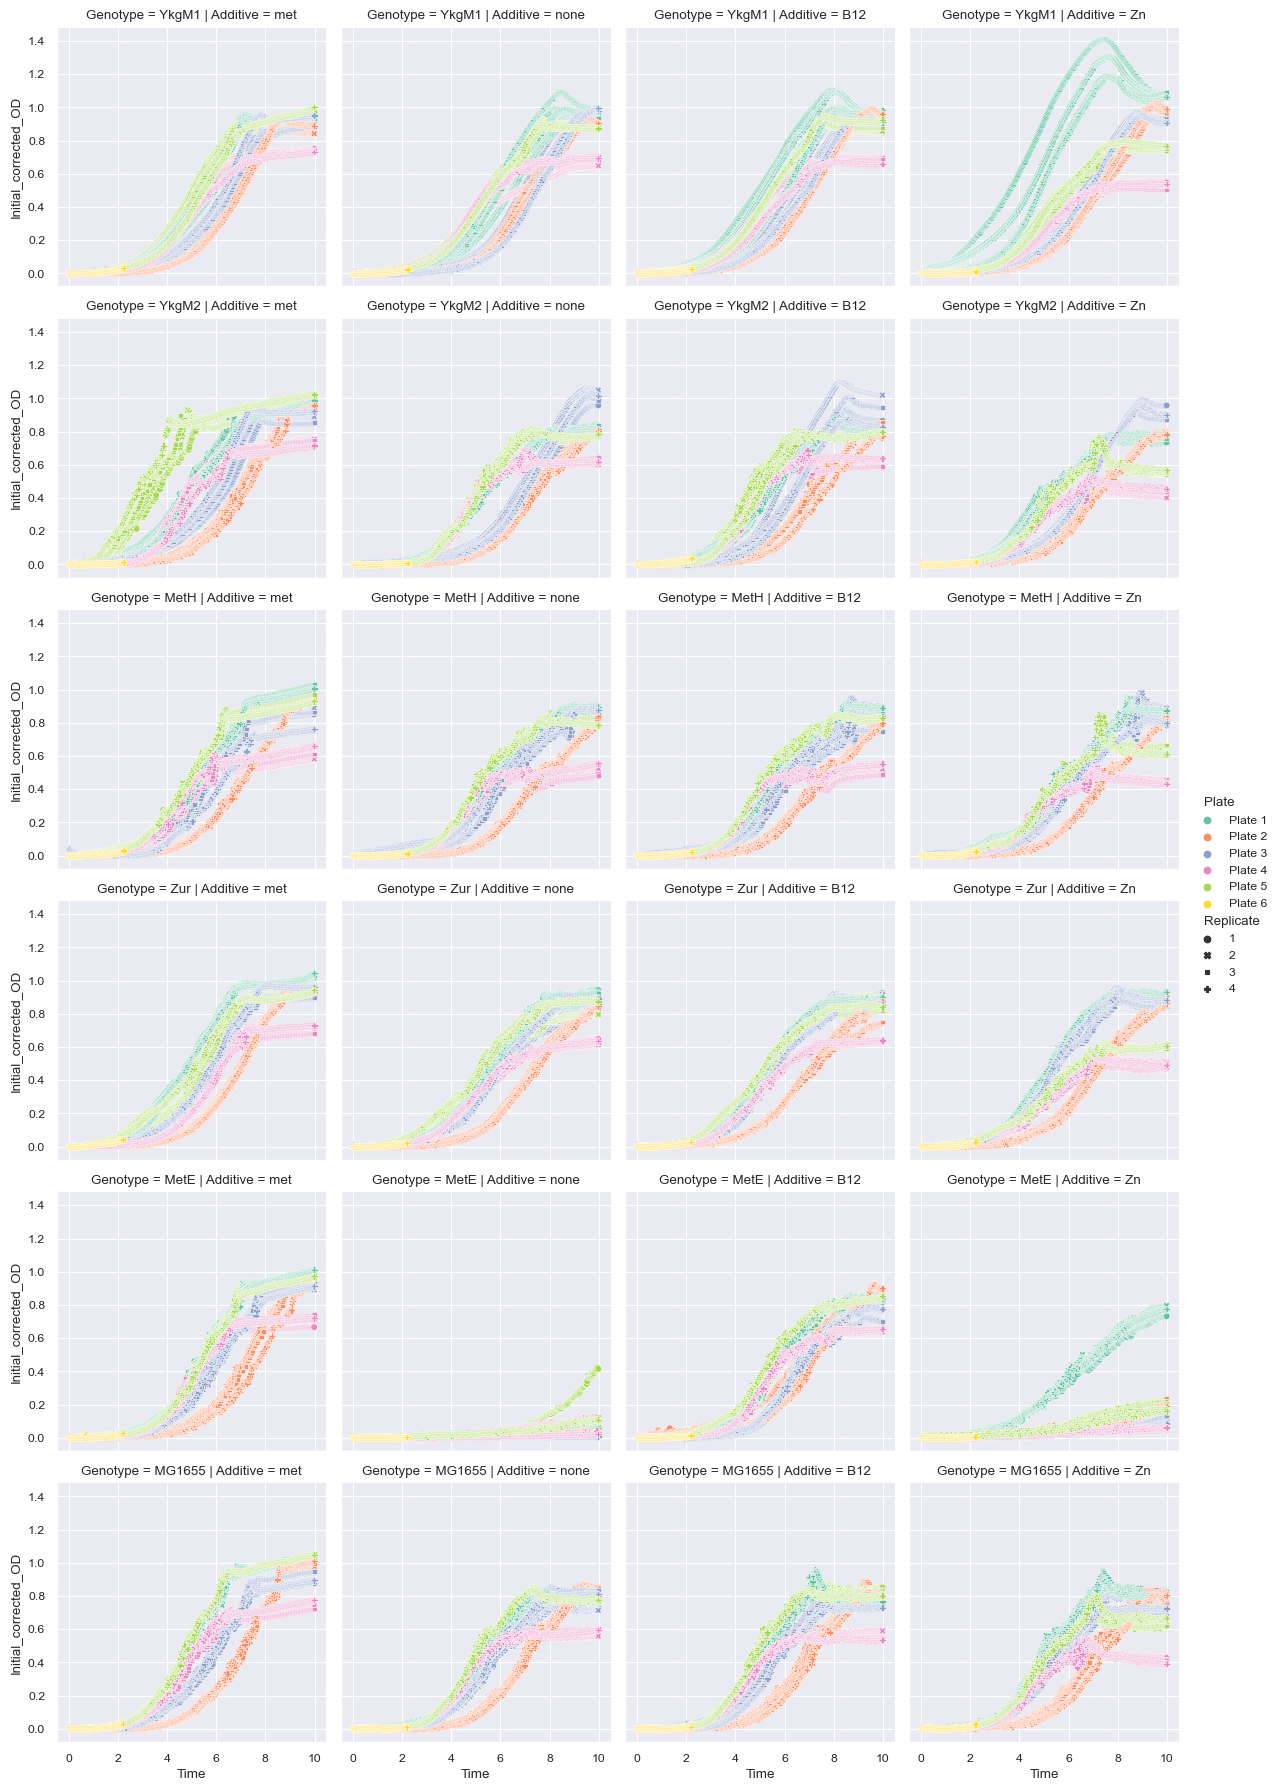

In [222]:
sns.set_context("paper")

sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", style="Replicate", kind="scatter", col="Additive", row="Genotype", height=3, \
            data=mdf.filter( (pl.col("Time") < 10) ))

In [223]:
f_mdf = mdf.filter(pl.col("Initial_corrected_OD") > 0)

f_mdf = f_mdf.with_columns([
    (pl.col("Initial_corrected_OD").log())
    .alias("Log_initial_corrected_OD")
])

f_mdf.head(5)

shape: (5, 12)
┌──────────┬─────────┬──────┬───────┬───┬────────────┬───────────┬────────────────┬────────────────┐
│ Time     ┆ Plate   ┆ Well ┆ OD    ┆ … ┆ Initial_OD ┆ Replicate ┆ Initial_correc ┆ Log_initial_co │
│ ---      ┆ ---     ┆ ---  ┆ ---   ┆   ┆ ---        ┆ ---       ┆ ted_OD         ┆ rrected_OD     │
│ f64      ┆ str     ┆ str  ┆ f64   ┆   ┆ f64        ┆ i32       ┆ ---            ┆ ---            │
│          ┆         ┆      ┆       ┆   ┆            ┆           ┆ f64            ┆ f64            │
╞══════════╪═════════╪══════╪═══════╪═══╪════════════╪═══════════╪════════════════╪════════════════╡
│ 0.011111 ┆ Plate 1 ┆ A1   ┆ 0.171 ┆ … ┆ 0.166      ┆ 1         ┆ 0.005          ┆ -5.298317      │
│ 0.036111 ┆ Plate 1 ┆ A1   ┆ 0.171 ┆ … ┆ 0.166      ┆ 1         ┆ 0.005          ┆ -5.298317      │
│ 0.061111 ┆ Plate 1 ┆ A1   ┆ 0.169 ┆ … ┆ 0.166      ┆ 1         ┆ 0.003          ┆ -5.809143      │
│ 0.086111 ┆ Plate 1 ┆ A1   ┆ 0.168 ┆ … ┆ 0.166      ┆ 1         ┆ 0.002          ┆ -6.214608      │
│ 0.111111 ┆ Plate 1 ┆ A1   ┆ 0.169 ┆ … ┆ 0.166      ┆ 1         ┆ 0.003          ┆ -5.809143      │
└──────────┴─────────┴──────┴───────┴───┴────────────┴───────────┴────────────────┴────────────────┘

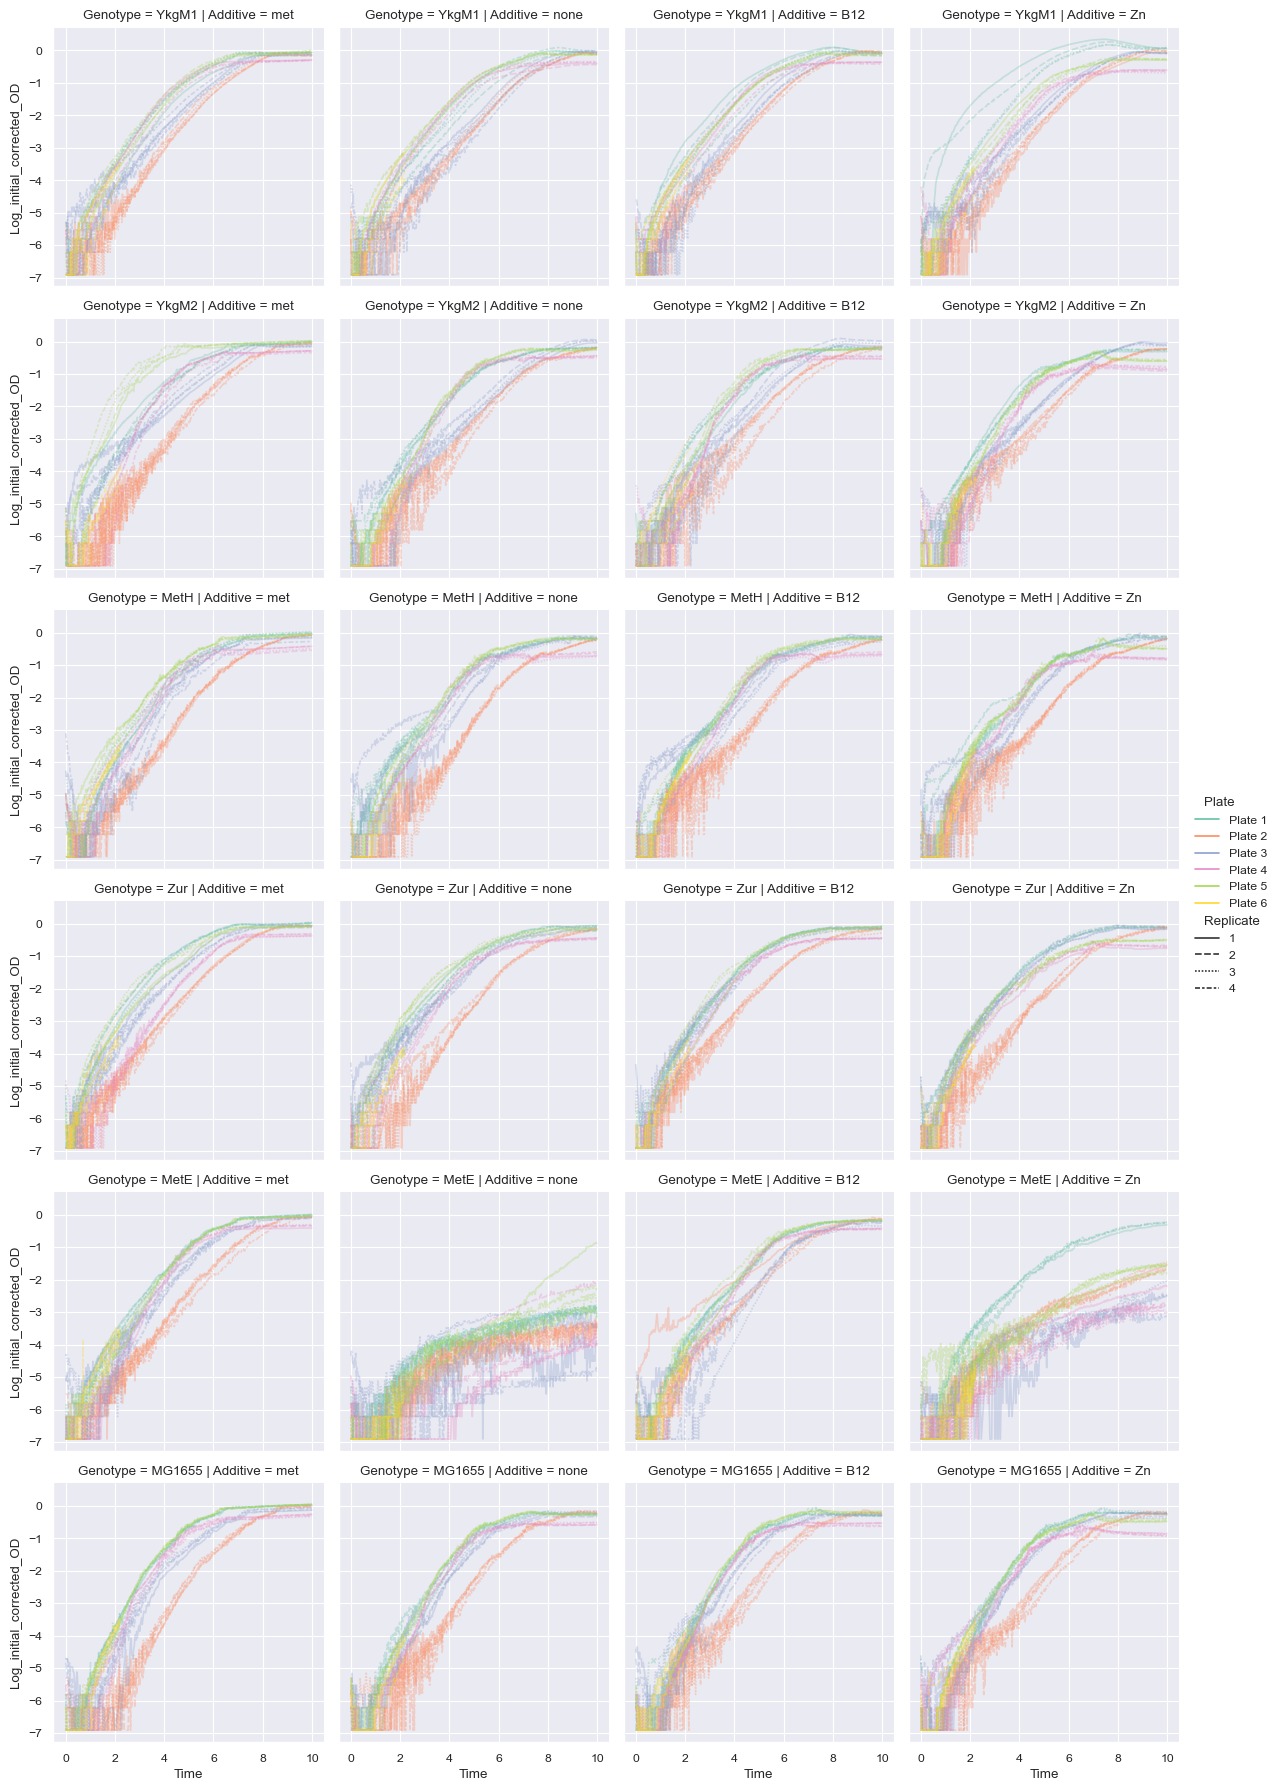

In [224]:
sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", style="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=f_mdf.filter(pl.col("Time") < 10), alpha=0.3)

# plt.savefig("Plate_comparison.png")

In [225]:
gr_df = f_mdf.filter( (pl.col("Time") < 20))
minimum_start_times = gr_df.filter(pl.col("Log_initial_corrected_OD") <= -5).group_by(["Plate", "Well"]).agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = gr_df.filter(pl.col("Log_initial_corrected_OD") >= -2).group_by(["Plate", "Well"]).agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

gr_df = gr_df.join(minimum_start_times, on=["Plate", "Well"])
gr_df = gr_df.join(minimum_end_times, on=["Plate", "Well"])
gr_df = gr_df.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_df = gr_df.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))
gr_df.head(5)

shape: (5, 15)
┌──────────┬─────────┬──────┬───────┬───┬──────────────┬──────────────┬──────────────┬─────────────┐
│ Time     ┆ Plate   ┆ Well ┆ OD    ┆ … ┆ Log_initial_ ┆ Time_exp_sta ┆ Time_exp_end ┆ Corrected_t │
│ ---      ┆ ---     ┆ ---  ┆ ---   ┆   ┆ corrected_OD ┆ rt           ┆ ---          ┆ ime         │
│ f64      ┆ str     ┆ str  ┆ f64   ┆   ┆ ---          ┆ ---          ┆ f64          ┆ ---         │
│          ┆         ┆      ┆       ┆   ┆ f64          ┆ f64          ┆              ┆ f64         │
╞══════════╪═════════╪══════╪═══════╪═══╪══════════════╪══════════════╪══════════════╪═════════════╡
│ 1.436111 ┆ Plate 1 ┆ A1   ┆ 0.173 ┆ … ┆ -4.961845    ┆ 1.411111     ┆ 3.911111     ┆ 0.025       │
│ 1.461111 ┆ Plate 1 ┆ A1   ┆ 0.173 ┆ … ┆ -4.961845    ┆ 1.411111     ┆ 3.911111     ┆ 0.05        │
│ 1.486111 ┆ Plate 1 ┆ A1   ┆ 0.173 ┆ … ┆ -4.961845    ┆ 1.411111     ┆ 3.911111     ┆ 0.075       │
│ 1.511111 ┆ Plate 1 ┆ A1   ┆ 0.173 ┆ … ┆ -4.961845    ┆ 1.411111     ┆ 3.911111     ┆ 0.1         │
│ 1.536111 ┆ Plate 1 ┆ A1   ┆ 0.174 ┆ … ┆ -4.828314    ┆ 1.411111     ┆ 3.911111     ┆ 0.125       │
└──────────┴─────────┴──────┴───────┴───┴──────────────┴──────────────┴──────────────┴─────────────┘

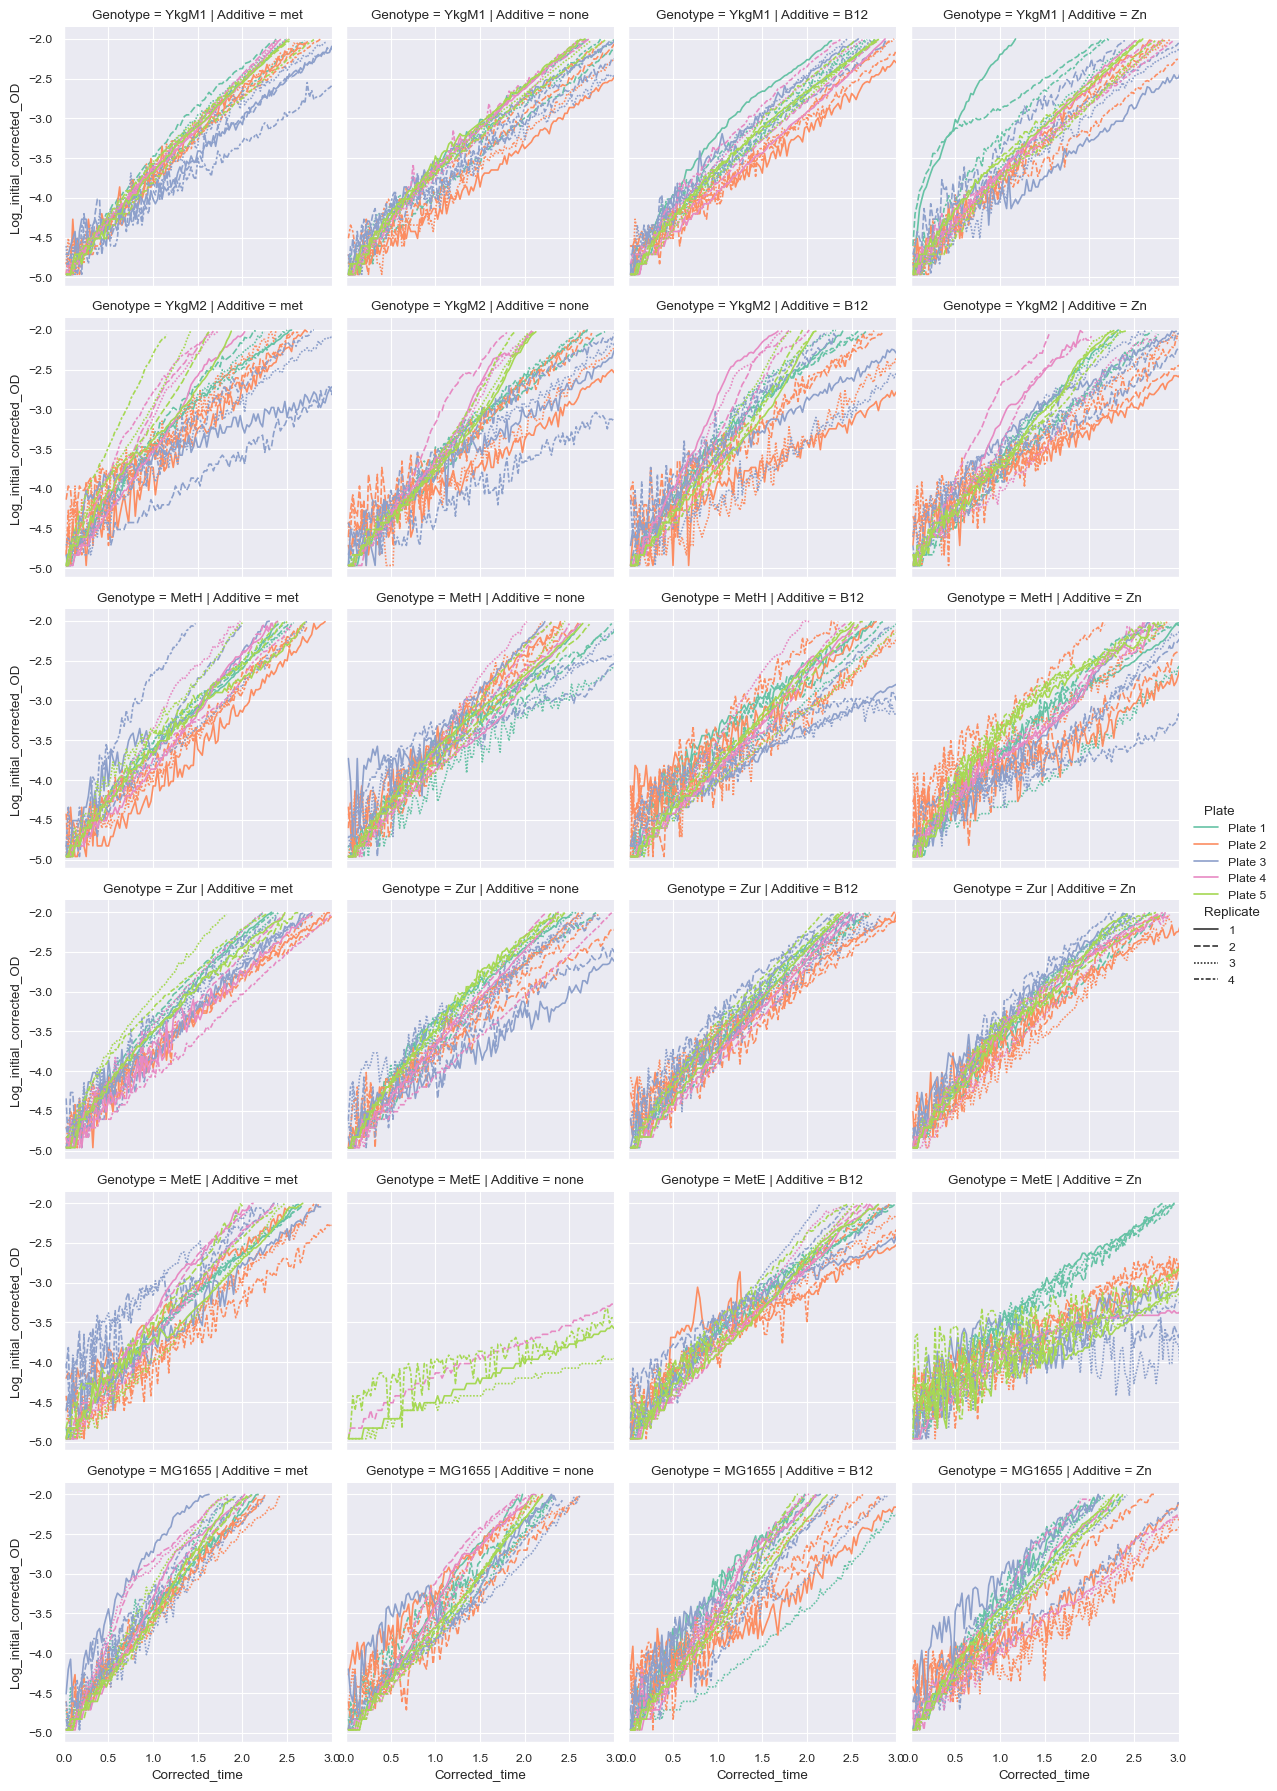

In [226]:
sns.relplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Plate", kind="line", col="Additive", style="Replicate", row="Genotype", height=3, \
            data=gr_df)

plt.xlim([0,3])

plt.savefig("shaky.png")

(0.0, 3.0)

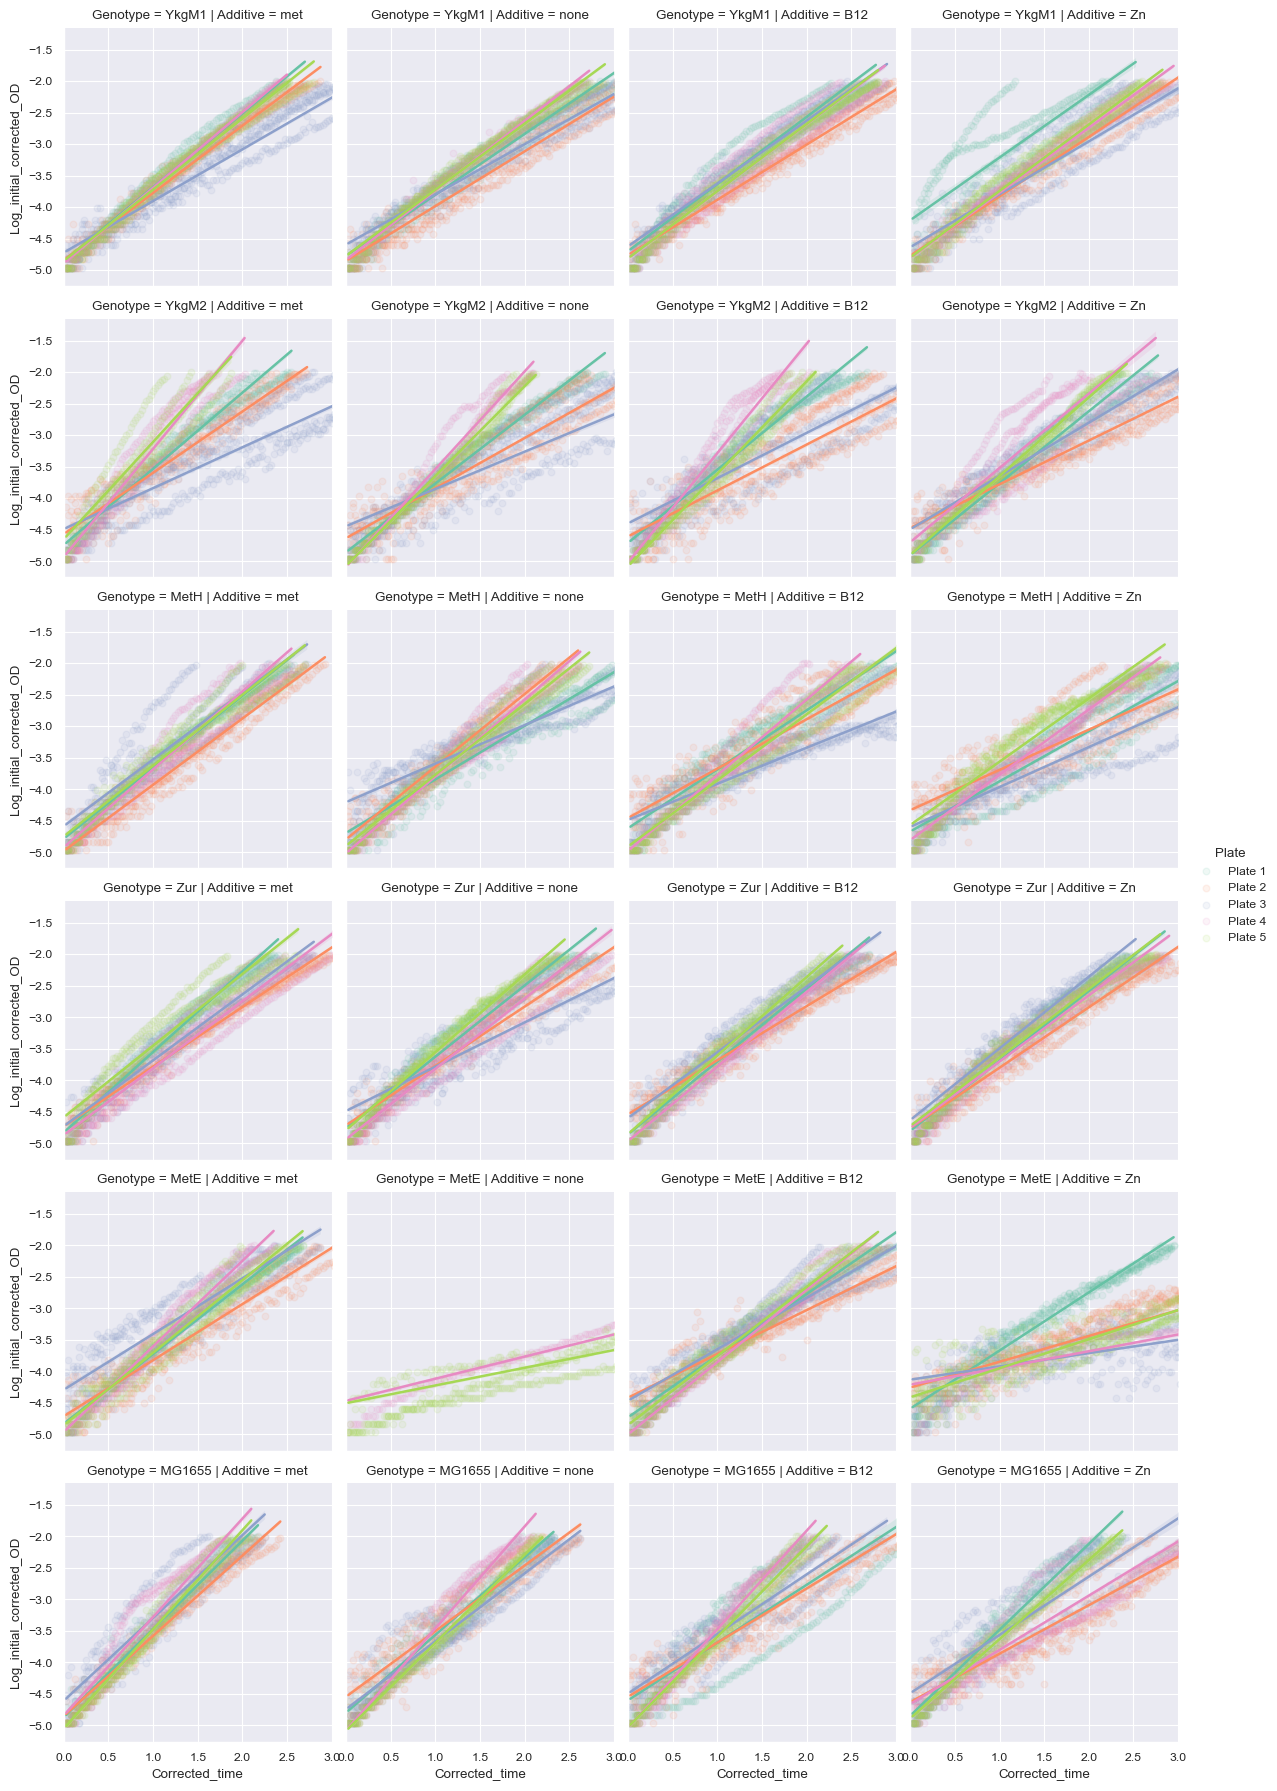

In [227]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Plate", col="Additive", row="Genotype", height=3, \
            data=gr_df.to_pandas(), scatter_kws = {"alpha": 0.1})

plt.xlim([0,3])


In [228]:
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std.columns = gr_mean_std.columns.get_level_values(1)
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std["mean"]
# gr_mean_std = gr_mean_std.reset_index()

predicted_gr["doubling_time"] = np.log(2)/predicted_gr["slope"]
predicted_gr

Genotype Additive  Replicate    Plate     slope  intercept   slope_e  \
0     MG1655      B12          1  Plate 1  1.429322  -4.722531  0.033186   
1     MG1655      B12          1  Plate 2  0.749287  -4.534751  0.018437   
2     MG1655      B12          1  Plate 3  1.180524  -4.498287  0.023660   
3     MG1655      B12          1  Plate 4  1.567000  -5.129915  0.019297   
4     MG1655      B12          1  Plate 5  1.336105  -5.000967  0.006378   
..       ...      ...        ...      ...       ...        ...       ...   
456      Zur     none          4  Plate 1  1.225542  -4.751628  0.017483   
457      Zur     none          4  Plate 2  0.998819  -4.808396  0.015331   
458      Zur     none          4  Plate 3  0.986774  -4.687617  0.021674   
459      Zur     none          4  Plate 4  1.003716  -5.049637  0.003616   
460      Zur     none          4  Plate 5  1.284691  -4.834224  0.013233   

     intercept_e  doubling_time  
0       0.038200       0.484948  
1       0.033731       0.925076  
2       0.029626       0.587152  
3       0.023605       0.442340  
4       0.008262       0.518782  
..           ...            ...  
456     0.023910       0.565584  
457     0.025170       0.693967  
458     0.035898       0.702438  
459     0.006250       0.690581  
460     0.017715       0.539544  

[461 rows x 9 columns]

(0.0, 1.0)

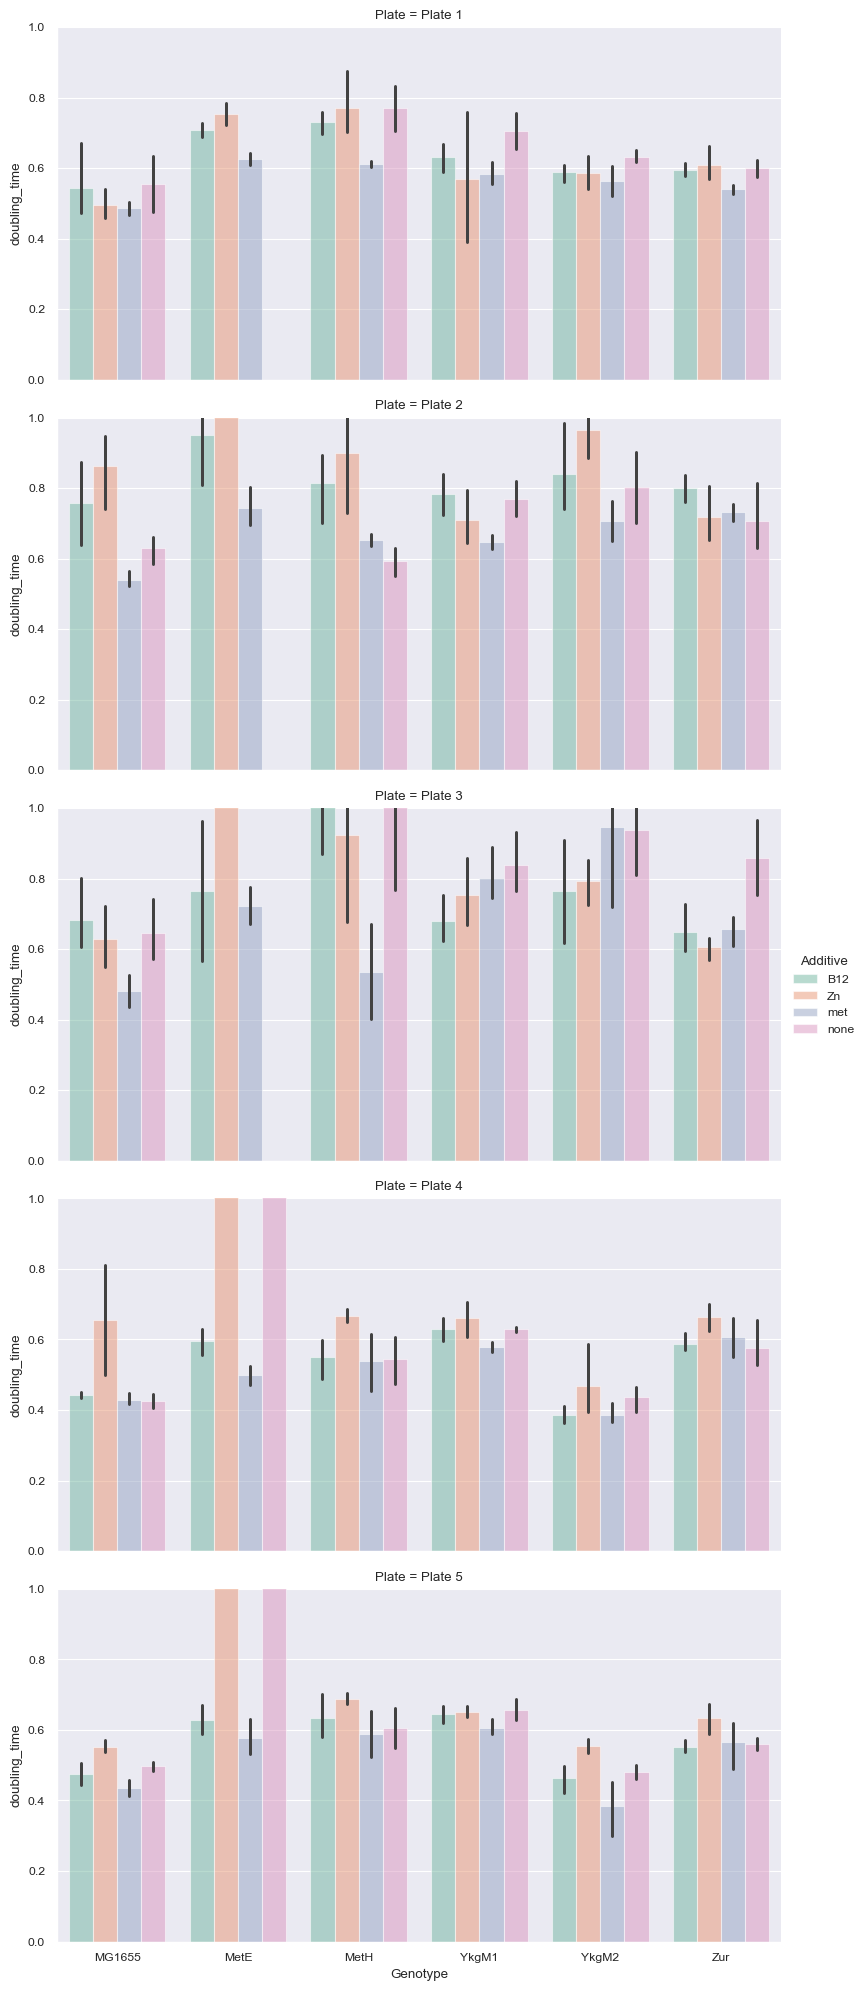

In [229]:
g = sns.catplot(x="Genotype", y="doubling_time", hue="Additive", row="Plate",
                data=predicted_gr, kind="bar",
                height=4, aspect=2, alpha=0.5);

plt.ylim([0,1])

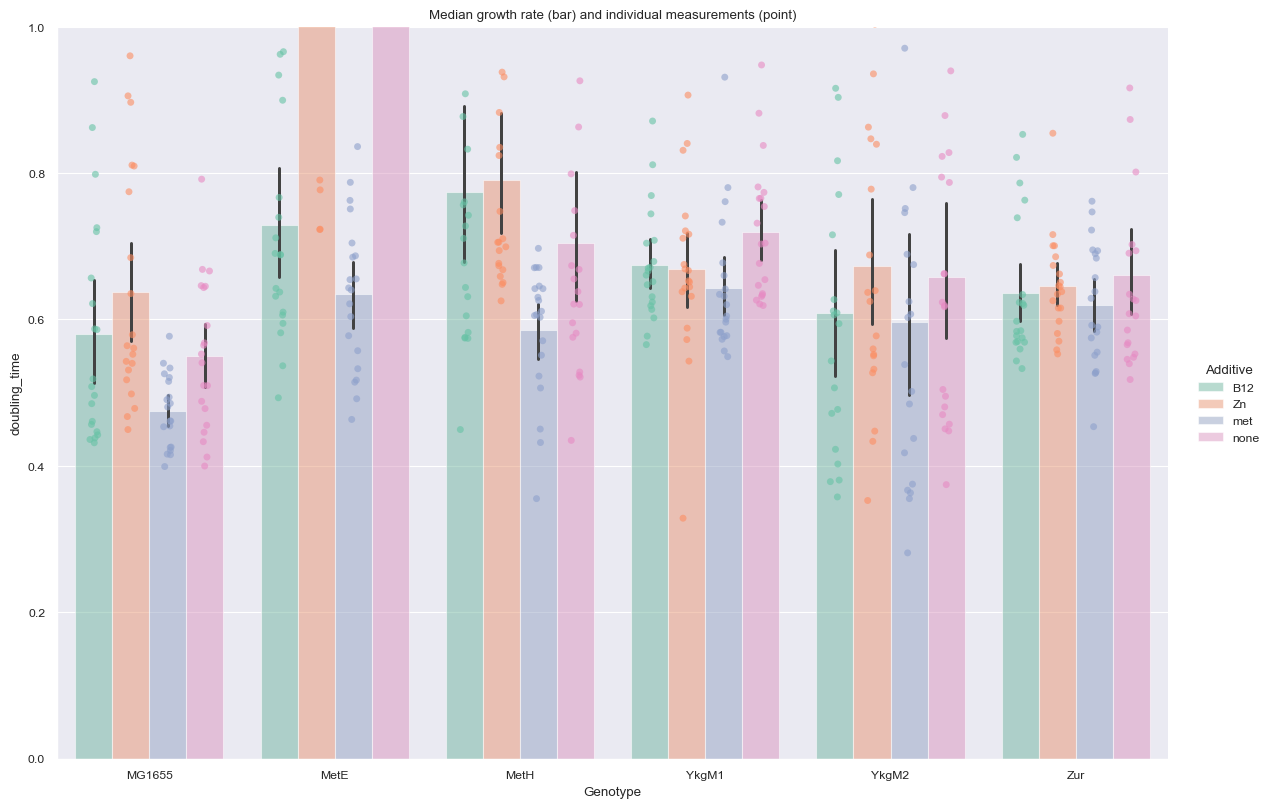

In [234]:
filter_df = pl.DataFrame(predicted_gr) #.filter((pl.col("Plate") == "Plate 2"))
filter_df.head(5)

g = sns.catplot(x="Genotype", y="doubling_time", hue="Additive", 
                data=filter_df.to_pandas(), kind="bar", 
                height=8, aspect=1.5, alpha=0.5);
g.map_dataframe(sns.stripplot, x="Genotype", y="doubling_time", 
                hue="Additive", palette="Set2",
                alpha=0.6, dodge=True)

plt.title("Median growth rate (bar) and individual measurements (point)")
# g.map(sns.stripplot, "sex", "total_bill", "smoker", 
#       palette=["#404040"], alpha=0.6, dodge=True)
plt.ylim([0, 1])

plt.show()

# Mut day two

## Importing data

In [74]:
additive = {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met", "F": "none", "G": "B12", "H": "Zn"}
adf = pl.DataFrame(additive).transpose(include_header=True)
adf = adf.rename({"column": "Row", "column_0": "Additive"})

genotype_row = [["A", "B", "C", "D"], ["E", "F", "G", "H"]]
genotype_col = [["1", "2", "3", "4"], ["5", "6", "7", "8"], ["9", "10", "11", "12"]]

genotype_combinations = {"YkgM1": [0, 0], "YkgM2": [0, 1], "MetH": [0, 2], "Zur": [1, 0], "MetE": [1, 1], "MG1655": [1, 2]}

gdf = []

for genotype, idx in genotype_combinations.items():

    gdf.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

gdf

gdf = pl.DataFrame(gdf).transpose()
gdf = gdf.rename({"column_0": "Genotype", "column_1": "Well"})

df = pl.read_csv("growth_data/cyrus_mutant_020124.txt", separator="\t")
df = df.drop('T600')
df.head(3)

blank_df = pl.read_csv("growth_data/cyrus_mutant_blanks_020124.txt", separator="\t")
blank_df = blank_df.drop(['T600', 'Time']).mean().transpose(include_header=True)
blank_df = blank_df.rename({"column": "Well", "column_0": "Background_OD"})
blank_df.head(3)

shape: (3, 2)
┌──────┬───────────────┐
│ Well ┆ Background_OD │
│ ---  ┆ ---           │
│ str  ┆ f64           │
╞══════╪═══════════════╡
│ A1   ┆ 0.094238      │
│ A2   ┆ 0.137952      │
│ A3   ┆ 0.179333      │
└──────┴───────────────┘

In [75]:
# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# initial measurement
init_df = df.drop("Time")[0:100,:].min().transpose(include_header=True)
init_df = init_df.rename({"column": "Well", "column_0": "Initial_OD"})

# melt to experiments
mdf = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
mdf = mdf.with_columns((mdf["Well"].str.slice(0,1)).alias("Row"))
mdf = mdf.with_columns((mdf["Well"].str.slice(1)).alias("Column"))

mdf = mdf.join(adf, on="Row")
mdf = mdf.join(gdf, on="Well")
mdf = mdf.join(blank_df, on="Well")
mdf = mdf.join(init_df, on="Well")

mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))

mdf



shape: (66_240, 10)
┌───────────┬──────┬───────┬─────┬───┬──────────┬───────────────┬────────────┬───────────┐
│ Time      ┆ Well ┆ OD    ┆ Row ┆ … ┆ Genotype ┆ Background_OD ┆ Initial_OD ┆ Replicate │
│ ---       ┆ ---  ┆ ---   ┆ --- ┆   ┆ ---      ┆ ---           ┆ ---        ┆ ---       │
│ f64       ┆ str  ┆ f64   ┆ str ┆   ┆ str      ┆ f64           ┆ f64        ┆ i32       │
╞═══════════╪══════╪═══════╪═════╪═══╪══════════╪═══════════════╪════════════╪═══════════╡
│ 0.011111  ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ YkgM1    ┆ 0.094238      ┆ 0.166      ┆ 1         │
│ 0.036111  ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ YkgM1    ┆ 0.094238      ┆ 0.166      ┆ 1         │
│ 0.061111  ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ YkgM1    ┆ 0.094238      ┆ 0.166      ┆ 1         │
│ 0.086111  ┆ A1   ┆ 0.168 ┆ A   ┆ … ┆ YkgM1    ┆ 0.094238      ┆ 0.166      ┆ 1         │
│ 0.111111  ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ YkgM1    ┆ 0.094238      ┆ 0.166      ┆ 1         │
│ …         ┆ …    ┆ …     ┆ …   ┆ … ┆ …        ┆ …             ┆ …          ┆ …         │
│ 17.136111 ┆ H12  ┆ 1.153 ┆ H   ┆ … ┆ MG1655   ┆ 0.102143      ┆ 0.168      ┆ 4         │
│ 17.161111 ┆ H12  ┆ 1.152 ┆ H   ┆ … ┆ MG1655   ┆ 0.102143      ┆ 0.168      ┆ 4         │
│ 17.186111 ┆ H12  ┆ 1.152 ┆ H   ┆ … ┆ MG1655   ┆ 0.102143      ┆ 0.168      ┆ 4         │
│ 17.211111 ┆ H12  ┆ 1.152 ┆ H   ┆ … ┆ MG1655   ┆ 0.102143      ┆ 0.168      ┆ 4         │
│ 17.236111 ┆ H12  ┆ 1.153 ┆ H   ┆ … ┆ MG1655   ┆ 0.102143      ┆ 0.168      ┆ 4         │
└───────────┴──────┴───────┴─────┴───┴──────────┴───────────────┴────────────┴───────────┘

In [76]:
mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Background_OD")).alias("Background_corrected_OD"), 
    (pl.col("OD") - pl.col("Initial_OD")).alias("Initial_corrected_OD"), 
    # (
    #     (pl.col("OD") - pl.col("Background_OD")) / (pl.col("Initial_OD") - pl.col("Background_OD"))  
    # ).alias("Normalized_OD")
])

mdf.head(5)



shape: (5, 12)
┌──────────┬──────┬───────┬─────┬───┬────────────┬───────────┬──────────────────┬──────────────────┐
│ Time     ┆ Well ┆ OD    ┆ Row ┆ … ┆ Initial_OD ┆ Replicate ┆ Background_corre ┆ Initial_correcte │
│ ---      ┆ ---  ┆ ---   ┆ --- ┆   ┆ ---        ┆ ---       ┆ cted_OD          ┆ d_OD             │
│ f64      ┆ str  ┆ f64   ┆ str ┆   ┆ f64        ┆ i32       ┆ ---              ┆ ---              │
│          ┆      ┆       ┆     ┆   ┆            ┆           ┆ f64              ┆ f64              │
╞══════════╪══════╪═══════╪═════╪═══╪════════════╪═══════════╪══════════════════╪══════════════════╡
│ 0.011111 ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ 0.166      ┆ 1         ┆ 0.076762         ┆ 0.005            │
│ 0.036111 ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ 0.166      ┆ 1         ┆ 0.076762         ┆ 0.005            │
│ 0.061111 ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ 0.166      ┆ 1         ┆ 0.074762         ┆ 0.003            │
│ 0.086111 ┆ A1   ┆ 0.168 ┆ A   ┆ … ┆ 0.166      ┆ 1         ┆ 0.073762         ┆ 0.002            │
│ 0.111111 ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ 0.166      ┆ 1         ┆ 0.074762         ┆ 0.003            │
└──────────┴──────┴───────┴─────┴───┴────────────┴───────────┴──────────────────┴──────────────────┘

## Plot raw data

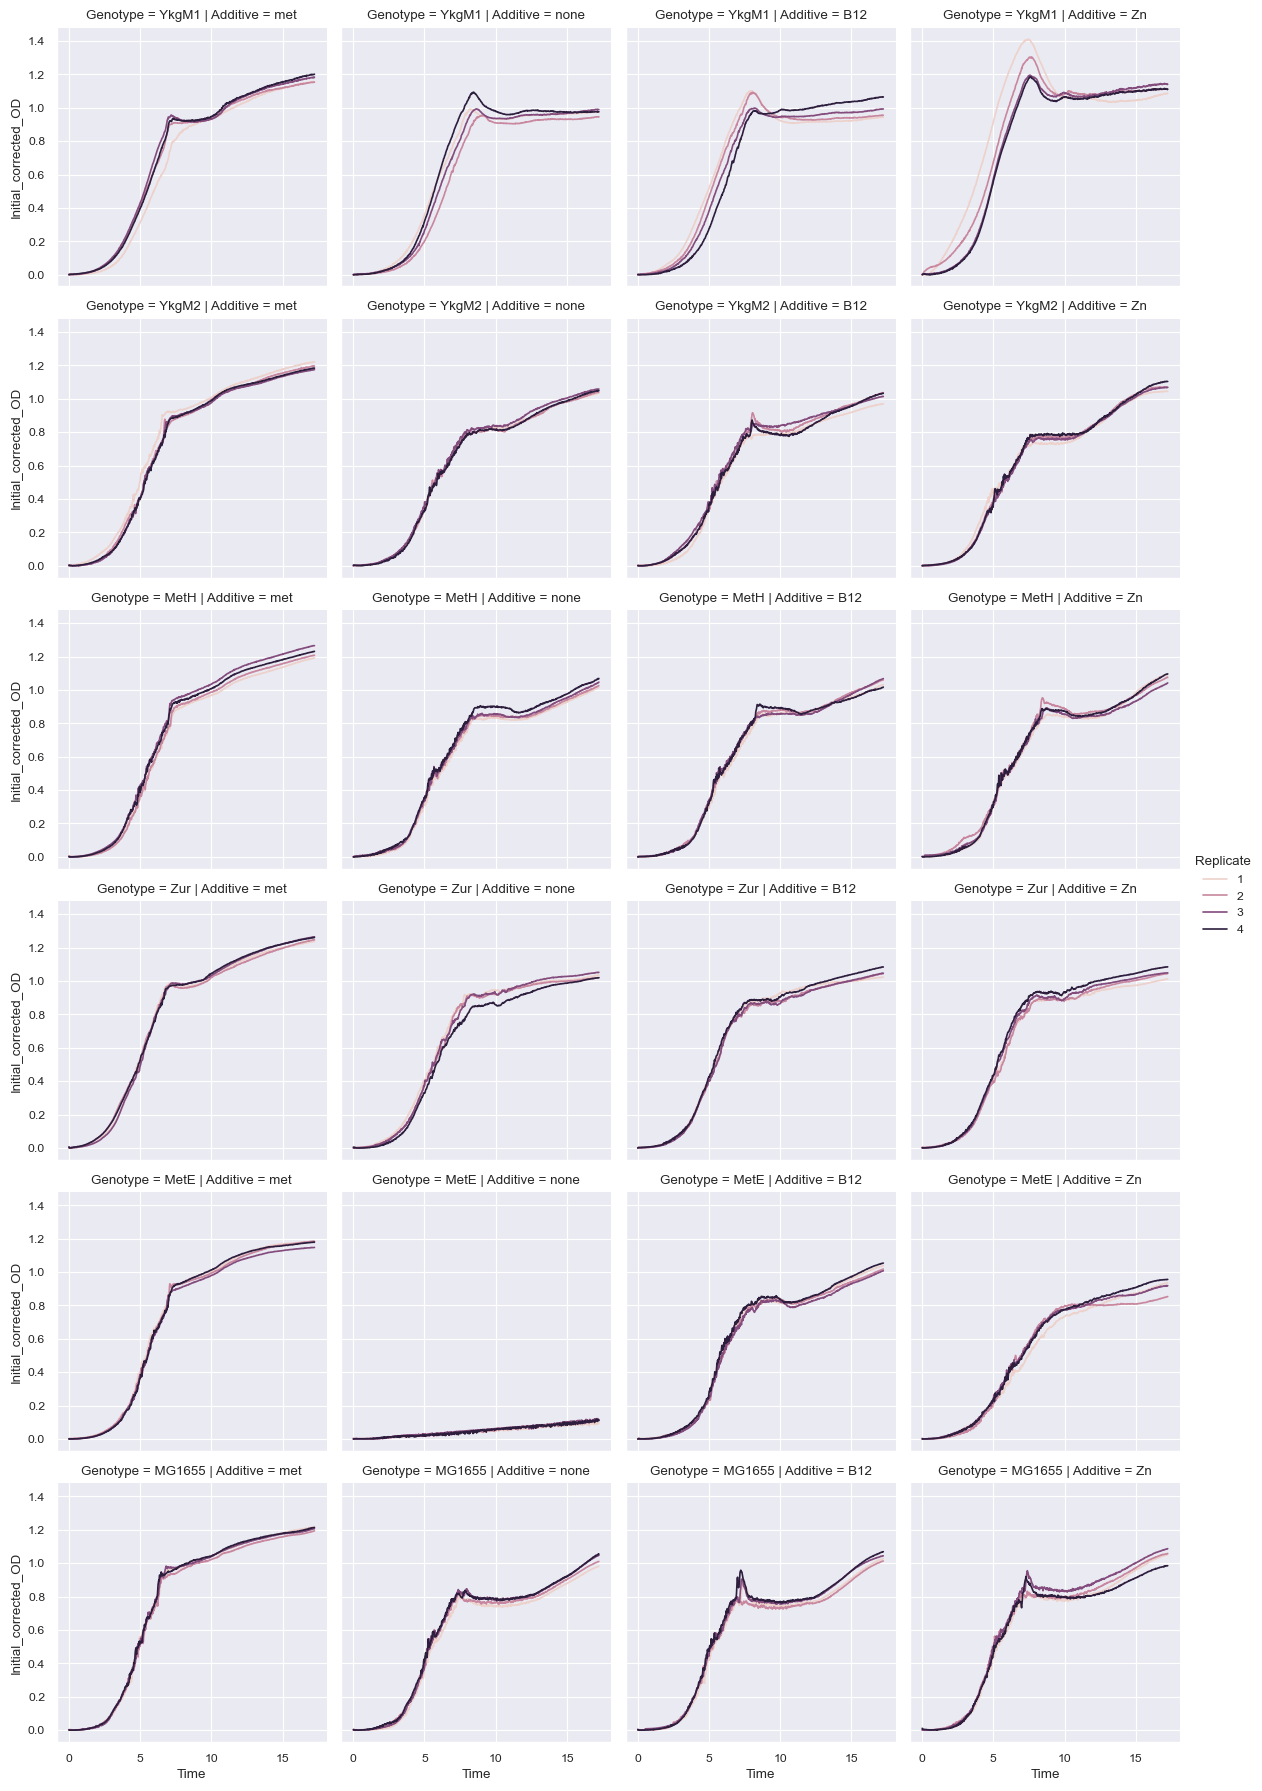

In [77]:
sns.relplot(x="Time", y="Initial_corrected_OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=mdf)

## Get growth rates

In [78]:
f_mdf = mdf.filter(pl.col("Initial_corrected_OD") > 0)

f_mdf = f_mdf.with_columns([
    (pl.col("Initial_corrected_OD").log())
    .alias("Log_initial_corrected_OD")
])

f_mdf.head(5)

shape: (5, 13)
┌──────────┬──────┬───────┬─────┬───┬───────────┬────────────────┬────────────────┬────────────────┐
│ Time     ┆ Well ┆ OD    ┆ Row ┆ … ┆ Replicate ┆ Background_cor ┆ Initial_correc ┆ Log_initial_co │
│ ---      ┆ ---  ┆ ---   ┆ --- ┆   ┆ ---       ┆ rected_OD      ┆ ted_OD         ┆ rrected_OD     │
│ f64      ┆ str  ┆ f64   ┆ str ┆   ┆ i32       ┆ ---            ┆ ---            ┆ ---            │
│          ┆      ┆       ┆     ┆   ┆           ┆ f64            ┆ f64            ┆ f64            │
╞══════════╪══════╪═══════╪═════╪═══╪═══════════╪════════════════╪════════════════╪════════════════╡
│ 0.011111 ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ 1         ┆ 0.076762       ┆ 0.005          ┆ -5.298317      │
│ 0.036111 ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ 1         ┆ 0.076762       ┆ 0.005          ┆ -5.298317      │
│ 0.061111 ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ 1         ┆ 0.074762       ┆ 0.003          ┆ -5.809143      │
│ 0.086111 ┆ A1   ┆ 0.168 ┆ A   ┆ … ┆ 1         ┆ 0.073762       ┆ 0.002          ┆ -6.214608      │
│ 0.111111 ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ 1         ┆ 0.074762       ┆ 0.003          ┆ -5.809143      │
└──────────┴──────┴───────┴─────┴───┴───────────┴────────────────┴────────────────┴────────────────┘

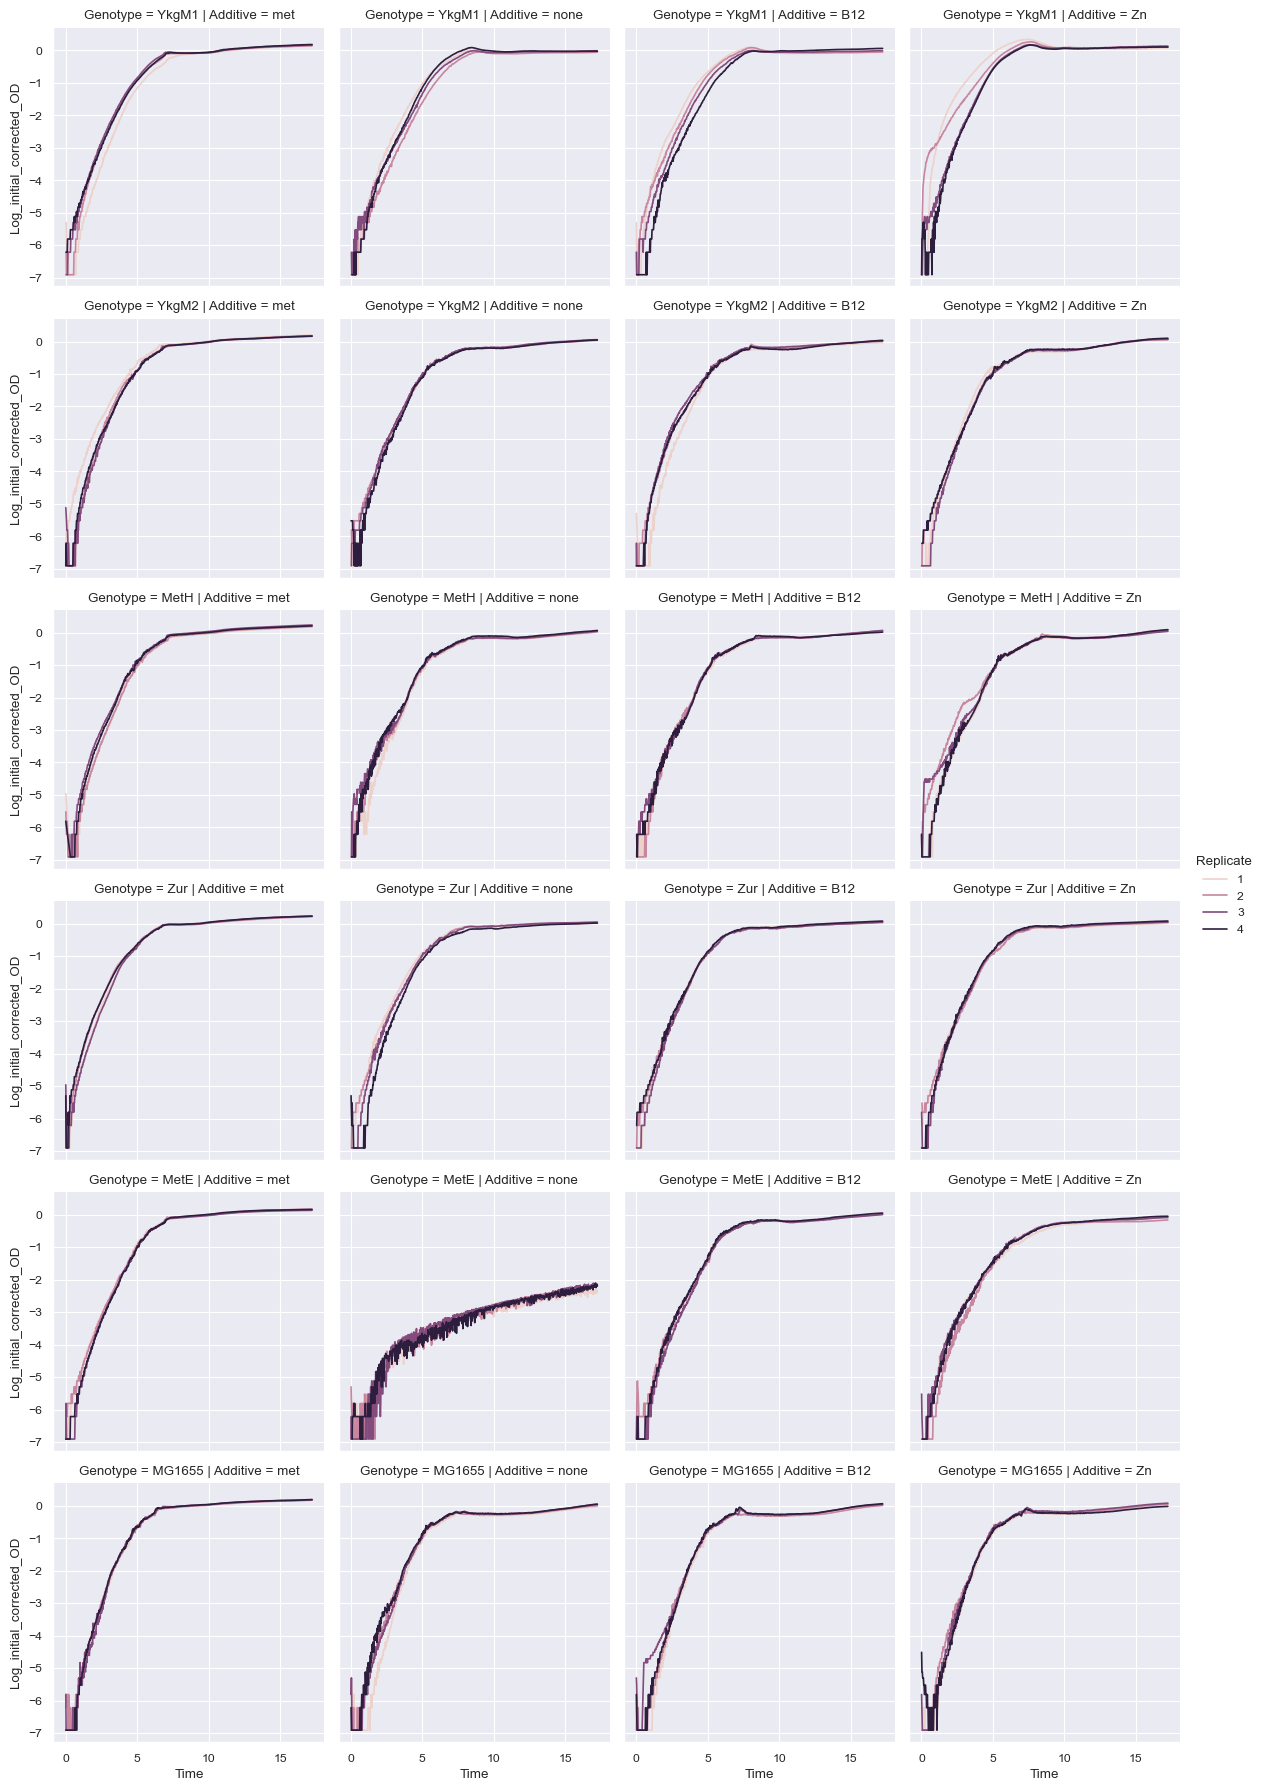

In [79]:
sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=f_mdf)

In [80]:
gr_df = f_mdf.filter( (pl.col("Time") < 10))
minimum_start_times = gr_df.filter(pl.col("Log_initial_corrected_OD") <= -4.5).group_by("Well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = gr_df.filter(pl.col("Log_initial_corrected_OD") >= -2).group_by("Well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

gr_df = gr_df.join(minimum_start_times, on="Well")
gr_df = gr_df.join(minimum_end_times, on="Well")
gr_df = gr_df.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_df = gr_df.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))
gr_df

shape: (8_150, 16)
┌──────────┬──────┬───────┬─────┬───┬───────────────┬───────────────┬──────────────┬───────────────┐
│ Time     ┆ Well ┆ OD    ┆ Row ┆ … ┆ Log_initial_c ┆ Time_exp_star ┆ Time_exp_end ┆ Corrected_tim │
│ ---      ┆ ---  ┆ ---   ┆ --- ┆   ┆ orrected_OD   ┆ t             ┆ ---          ┆ e             │
│ f64      ┆ str  ┆ f64   ┆ str ┆   ┆ ---           ┆ ---           ┆ f64          ┆ ---           │
│          ┆      ┆       ┆     ┆   ┆ f64           ┆ f64           ┆              ┆ f64           │
╞══════════╪══════╪═══════╪═════╪═══╪═══════════════╪═══════════════╪══════════════╪═══════════════╡
│ 1.811111 ┆ A1   ┆ 0.178 ┆ A   ┆ … ┆ -4.422849     ┆ 1.786111      ┆ 3.911111     ┆ 0.025         │
│ 1.836111 ┆ A1   ┆ 0.178 ┆ A   ┆ … ┆ -4.422849     ┆ 1.786111      ┆ 3.911111     ┆ 0.05          │
│ 1.861111 ┆ A1   ┆ 0.178 ┆ A   ┆ … ┆ -4.422849     ┆ 1.786111      ┆ 3.911111     ┆ 0.075         │
│ 1.886111 ┆ A1   ┆ 0.18  ┆ A   ┆ … ┆ -4.268698     ┆ 1.786111      ┆ 3.911111     ┆ 0.1           │
│ 1.911111 ┆ A1   ┆ 0.18  ┆ A   ┆ … ┆ -4.268698     ┆ 1.786111      ┆ 3.911111     ┆ 0.125         │
│ …        ┆ …    ┆ …     ┆ …   ┆ … ┆ …             ┆ …             ┆ …            ┆ …             │
│ 3.461111 ┆ H12  ┆ 0.28  ┆ H   ┆ … ┆ -2.189256     ┆ 1.886111      ┆ 3.586111     ┆ 1.575         │
│ 3.486111 ┆ H12  ┆ 0.281 ┆ H   ┆ … ┆ -2.180367     ┆ 1.886111      ┆ 3.586111     ┆ 1.6           │
│ 3.511111 ┆ H12  ┆ 0.285 ┆ H   ┆ … ┆ -2.145581     ┆ 1.886111      ┆ 3.586111     ┆ 1.625         │
│ 3.536111 ┆ H12  ┆ 0.291 ┆ H   ┆ … ┆ -2.095571     ┆ 1.886111      ┆ 3.586111     ┆ 1.65          │
│ 3.561111 ┆ H12  ┆ 0.297 ┆ H   ┆ … ┆ -2.047943     ┆ 1.886111      ┆ 3.586111     ┆ 1.675         │
└──────────┴──────┴───────┴─────┴───┴───────────────┴───────────────┴──────────────┴───────────────┘

(0.0, 4.0)

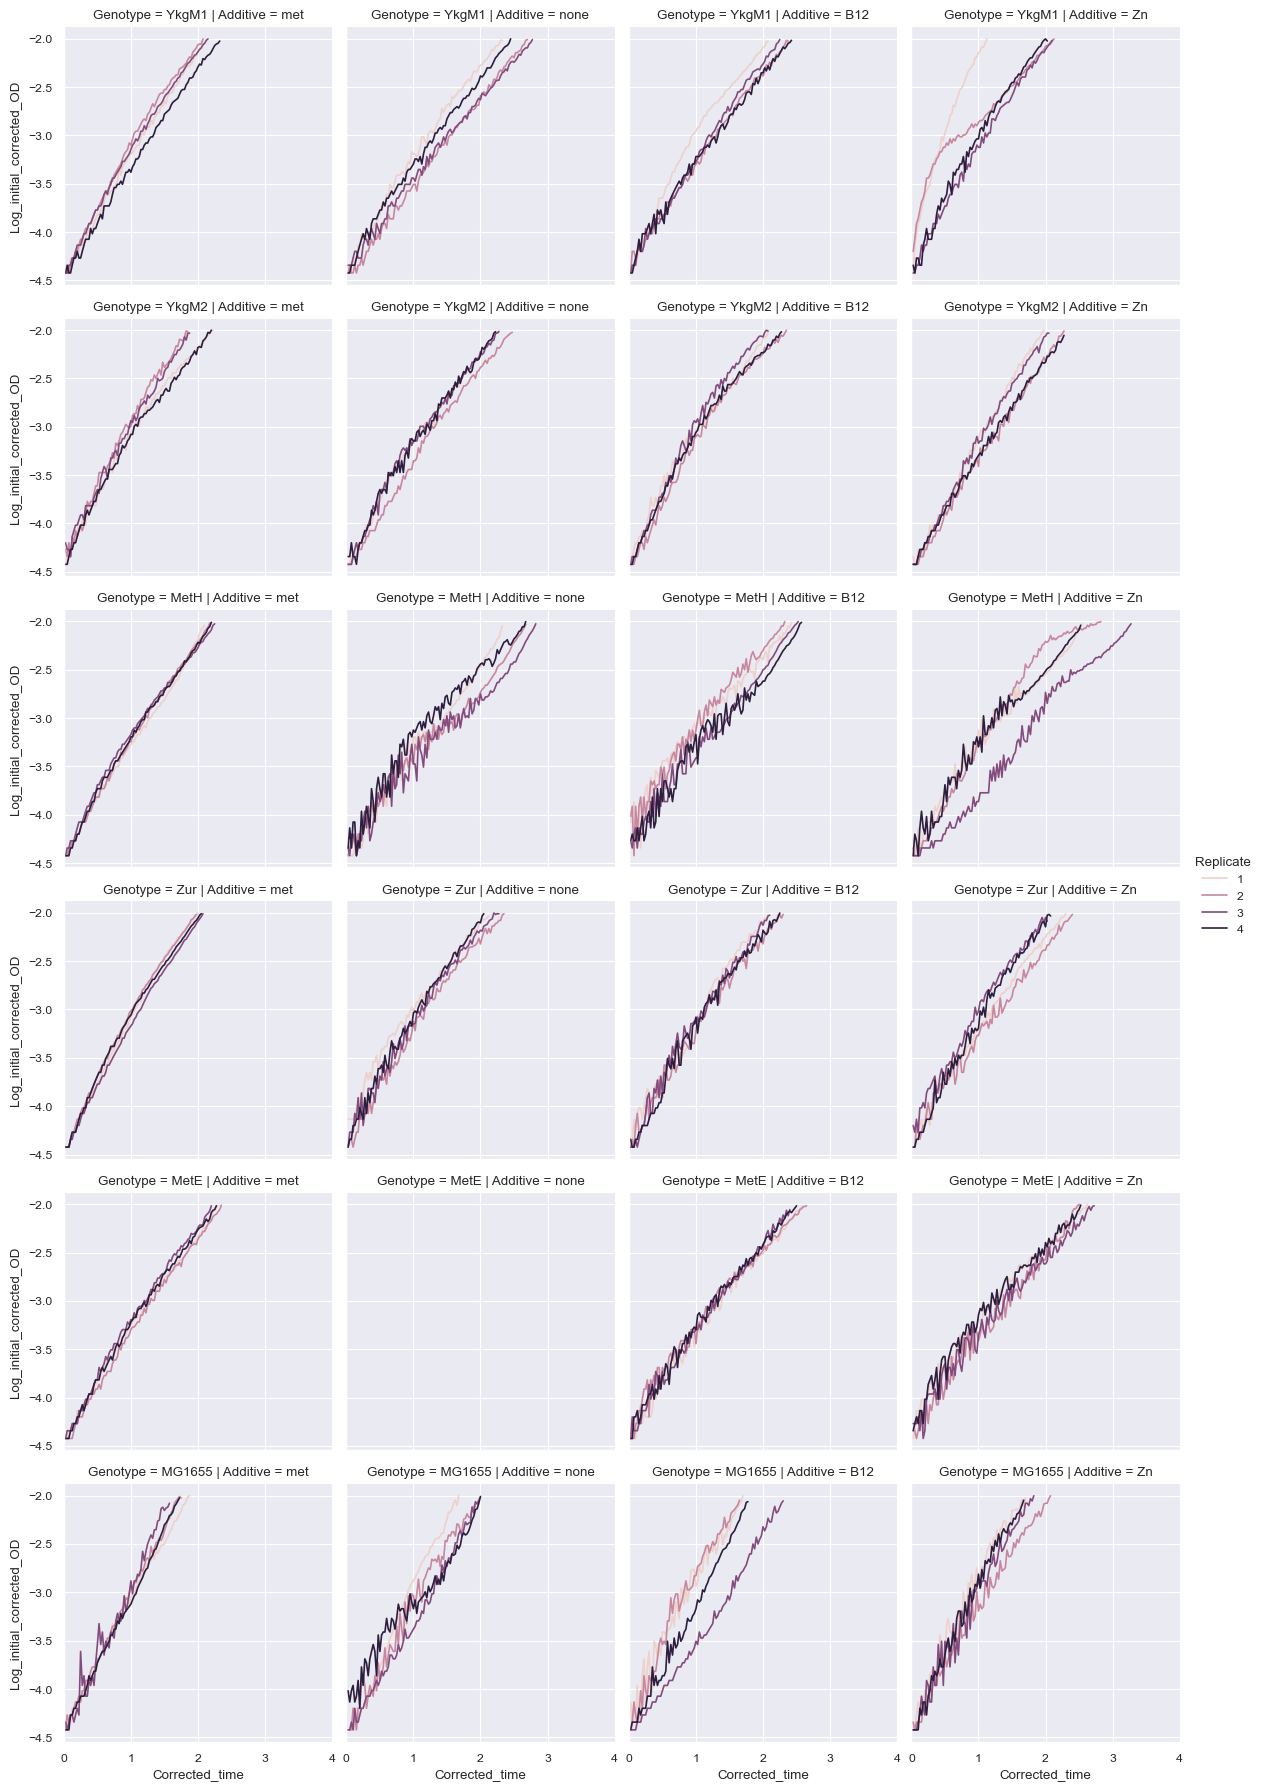

In [81]:
sns.relplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=gr_df)

plt.xlim([0,4])

In [82]:
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std.columns = gr_mean_std.columns.get_level_values(1)
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std["mean"]
# gr_mean_std = gr_mean_std.reset_index()

predicted_gr["doubling_time"] = np.log(2)/predicted_gr["slope"]
predicted_gr

Genotype Additive  Replicate     slope  intercept   slope_e  intercept_e  \
0    MG1655      B12          1  1.324157  -4.212585  0.034644     0.034378   
1    MG1655      B12          2  1.427234  -4.281178  0.031208     0.030067   
2    MG1655      B12          3  1.066257  -4.564200  0.009580     0.012825   
3    MG1655      B12          4  1.347420  -4.479041  0.013150     0.013619   
4    MG1655       Zn          1  1.431332  -4.309911  0.028843     0.028621   
..      ...      ...        ...       ...        ...       ...          ...   
87      Zur      met          4  1.190536  -4.325590  0.014427     0.017232   
88      Zur     none          1  0.986011  -4.028845  0.013609     0.016844   
89      Zur     none          2  1.039713  -4.312025  0.012869     0.017600   
90      Zur     none          3  1.050107  -4.238075  0.013530     0.017918   
91      Zur     none          4  1.132044  -4.259421  0.013438     0.016051   

    doubling_time  
0        0.523463  
1        0.485658  
2        0.650075  
3        0.514426  
4        0.484267  
..            ...  
87       0.582215  
88       0.702981  
89       0.666672  
90       0.660073  
91       0.612297  

[92 rows x 8 columns]

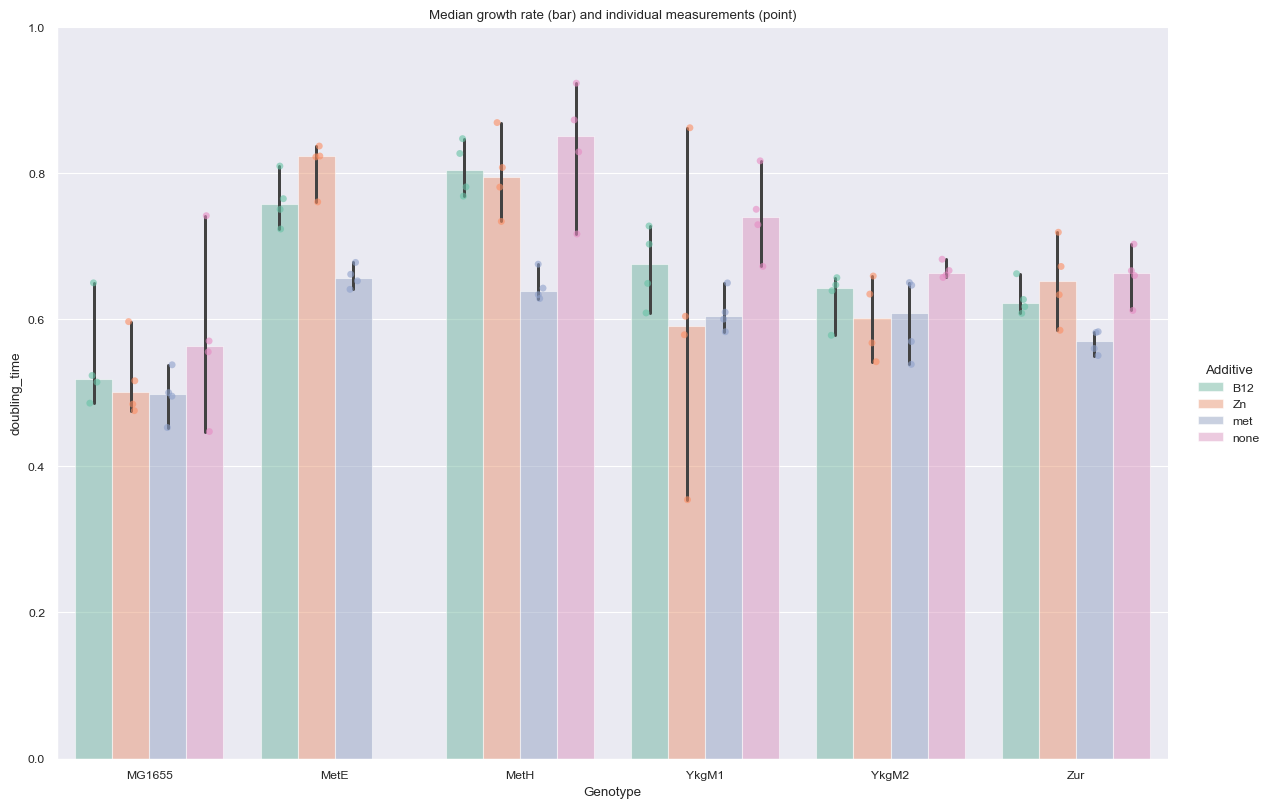

In [83]:
g = sns.catplot(x="Genotype", y="doubling_time", hue="Additive", 
                data=predicted_gr, kind="bar", estimator="median",
                height=8, aspect=1.5, alpha=0.5);
g.map_dataframe(sns.stripplot, x="Genotype", y="doubling_time", 
                hue="Additive", palette="Set2",
                alpha=0.6, dodge=True)

plt.title("Median growth rate (bar) and individual measurements (point)")
# g.map(sns.stripplot, "sex", "total_bill", "smoker", 
#       palette=["#404040"], alpha=0.6, dodge=True)
plt.ylim([0, 1])

plt.show()

## Slope fits

In [12]:
rerun_fits = False

import warnings
warnings.filterwarnings('ignore')

wells = list(f_mdf["Well"].unique())
timepoints = list(f_mdf["Time"].unique())
window = 50

well_fits = {}

if rerun_fits == True:
    for well in wells:
    
        fits = []
        
        for i, time in enumerate(timepoints):
    
            
            cur_df = f_mdf.filter(
                (pl.col("Well") == well) & 
                (pl.col("Time").is_in(timepoints[i:i+window]) )
            )
    
            fit = np.polyfit(cur_df["Time"],cur_df["Log_initial_corrected_OD"], 1)[0]
    
            fits.append(fit)
    
            # print(f"for well {well} at time {time}, the instantenous slope is {fit}")
    
        well_fits[well] = fits



In [13]:
rerun_fit_plots = False

if rerun_fit_plots == True:
    wf_df = pl.DataFrame(well_fits)
    wf_df = wf_df.with_columns(pl.arange(0, len(wf_df)).alias("Step"))
    
    
    # melt to experiments
    wf_df = wf_df.melt(id_vars="Step", variable_name="Well", value_name="Slope")
    wf_df = wf_df.with_columns((wf_df["Well"].str.slice(0,1)).alias("Row"))
    wf_df = wf_df.with_columns((wf_df["Well"].str.slice(1)).alias("Column"))
    
    wf_df = wf_df.join(adf, on="Row")
    wf_df = wf_df.join(gdf, on="Well")
    
    wf_df = wf_df.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))
    
    wf_df.head(5)

    sns.relplot(x="Step", y="Slope", kind="line", col="Additive", row="Genotype", height=3, \
            data=wf_df.filter(
                (pl.col("Step") > 50) & (pl.col("Step") < 200) & (pl.col("Slope") > 0)  & (pl.col("Slope") < 2.5)
            )
           )

## Test of linear fit

(0.0, 4.0)

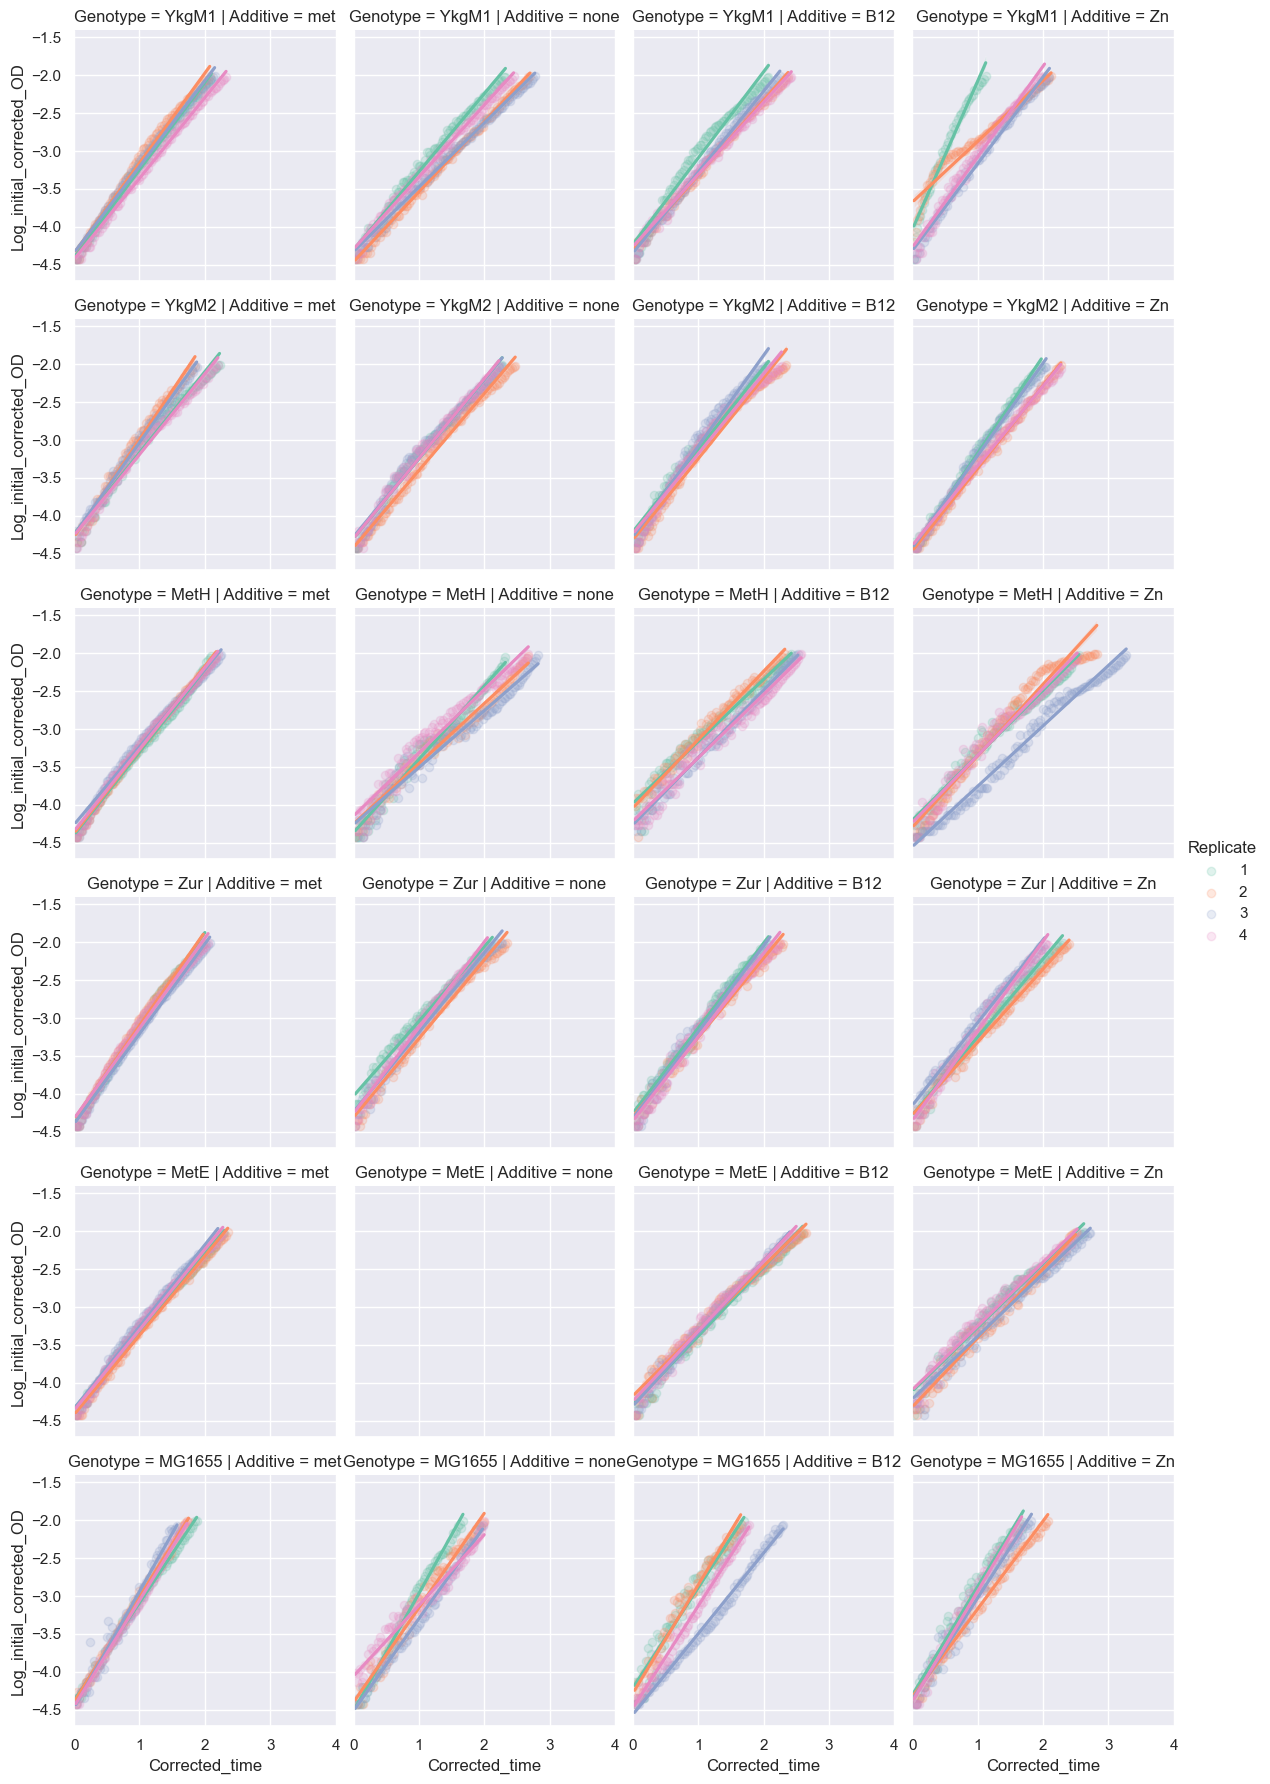

In [14]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Replicate", col="Additive", row="Genotype", height=3, \
            data=gr_df.to_pandas(), scatter_kws = {"alpha": 0.2})

plt.xlim([0,4])

# Mut

In [ ]:
additive = {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met", "F": "none", "G": "B12", "H": "Zn"}
adf = pl.DataFrame(additive).transpose(include_header=True)
adf = adf.rename({"column": "Row", "column_0": "Additive"})

In [ ]:
genotype_row = [["A", "B", "C", "D"], ["E", "F", "G", "H"]]
genotype_col = [["1", "2", "3", "4"], ["5", "6", "7", "8"], ["9", "10", "11", "12"]]

genotype_combinations = {"YkgM1": [0, 0], "YkgM2": [0, 1], "MetH": [0, 2], "Zur": [1, 0], "MetE": [1, 1], "MG1655": [1, 2]}

In [ ]:
gdf = []

for genotype, idx in genotype_combinations.items():

    gdf.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

gdf

gdf = pl.DataFrame(gdf).transpose()
gdf = gdf.rename({"column_0": "Genotype", "column_1": "Well"})

In [ ]:
df = pl.read_csv("growth_data/cyrus_mutant_013124.txt", separator="\t")
df = df.drop('T600')
df.head(3)

In [ ]:
# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# zero by first measurement
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

# melt to experiments
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Row"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Column"))

df = df.filter(pl.col("OD") > 0)

mdf = df.join(adf, on="Row")
mdf = mdf.join(gdf, on="Well")
mdf

mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))
mdf.head(3)

In [ ]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=mdf.filter( (pl.col("Time") < 10) & (pl.col("Time") > 2) ))

In [ ]:
mdf = mdf.with_columns(pl.col("OD").log())

In [ ]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=mdf.filter( (pl.col("Time") < 10)))

In [ ]:
growth_rate_precise = mdf.filter( (pl.col("Time") < 10))

minimum_start_times = growth_rate_precise.filter(pl.col("OD") <= -4).group_by("Well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = growth_rate_precise.filter(pl.col("OD") >= -1).group_by("Well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

growth_rate_precise = growth_rate_precise.join(minimum_start_times, on="Well")
growth_rate_precise = growth_rate_precise.join(minimum_end_times, on="Well")
gr_time_filter = growth_rate_precise.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_time_filter = gr_time_filter.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))

# correct all od values to start at 0
# start_od = gr_time_filter.group_by("Well").agg(pl.min("OD").alias("Start_OD")).sort("Start_OD")
# gr_time_filter = gr_time_filter.join(start_od, on="Well")
# gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("Start_OD")).alias("Corrected_OD"))

# correct by linear fit

#This is what you need
correction_offset = gr_time_filter.to_pandas().groupby('Well').apply(regress, 'OD', ['Corrected_time'])
correction_offset = correction_offset.reset_index()
correction_offset = pl.DataFrame(correction_offset)

gr_time_filter

In [ ]:
sns.relplot(x="Corrected_time", y="OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=gr_time_filter)

In [ ]:
sns.lmplot(x="Corrected_time", y="OD", hue="Additive", col="Genotype", col_wrap=3, height=4, 
           data=gr_time_filter.to_pandas(), scatter_kws = {"alpha": 0.2})

In [ ]:
predicted_gr = gr_time_filter \
.to_pandas().groupby(['Genotype', 'Additive','Replicate']).apply(regress_error, 'OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std.xs('slope',  axis=1)["mean"]
gr_mean_std

In [ ]:
g = sns.catplot(x="Genotype", y="doubling_time", hue="Additive", 
                data=predicted_gr, kind="bar",
                height=8, aspect=1.5, alpha=0.5);
g.map_dataframe(sns.stripplot, x="Genotype", y="doubling_time", 
                hue="Additive", palette="Set2",
                alpha=0.6, dodge=True)
# g.map(sns.stripplot, "sex", "total_bill", "smoker", 
#       palette=["#404040"], alpha=0.6, dodge=True)
plt.show()

# Reanalyzing the old plate lol

In [ ]:
# plate 2
df = pl.read_csv("growth_data/cyrus_012624.csv")
df = df.drop('T600')

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# zero by first measurement
# df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

# melt to experiments
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df = df.with_columns(pl.col("OD").log())


In [ ]:
# join with experiment type
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names

exp

In [ ]:
mdf = df.join(exp, on="Experiment")

In [ ]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", col="Additive", row="Pre-met", height=3, \
            data=mdf.filter( (pl.col("Time") < 10) & (pl.col("Time") > 0) ))

In [ ]:
growth_rate_precise = mdf.filter( (pl.col("Time") < 10))

minimum_start_times = growth_rate_precise.filter(pl.col("OD") <= -0.9).group_by("Well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = growth_rate_precise.filter(pl.col("OD") >= -0.5).group_by("Well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

growth_rate_precise = growth_rate_precise.join(minimum_start_times, on="Well")
growth_rate_precise = growth_rate_precise.join(minimum_end_times, on="Well")
gr_time_filter = growth_rate_precise.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_time_filter = gr_time_filter.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))

# correct all od values to start at 0
# start_od = gr_time_filter.group_by("Well").agg(pl.min("OD").alias("Start_OD")).sort("Start_OD")
# gr_time_filter = gr_time_filter.join(start_od, on="Well")
# gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("Start_OD")).alias("Corrected_OD"))

# correct by linear fit

#This is what you need
correction_offset = gr_time_filter.to_pandas().groupby('Well').apply(regress, 'OD', ['Corrected_time'])
correction_offset = correction_offset.reset_index()
correction_offset = pl.DataFrame(correction_offset)

gr_time_filter = gr_time_filter.join(correction_offset, on="Well")
gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("intercept")).alias("Corrected_OD"))

gr_time_filter

In [ ]:
sns.relplot(x="Corrected_time", y="OD", hue="Replicate", kind="line", col="Additive", row="Pre-met", height=3, \
            data=gr_time_filter.filter( (pl.col("Time") < 10) & (pl.col("Time") > 0) ))

In [ ]:
sns.lmplot(x="Corrected_time", y="OD", hue="Additive", col="Pre-met", col_wrap=3, height=4, 
           data=gr_time_filter.to_pandas(), scatter_kws = {"alpha": 0.2})

# All plates at once:

In [ ]:
# plate 1
df = pl.read_csv("growth_data/adrian_growth_jan25_v2.csv")
df = df.drop('T600')

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(3600 * df['Time'].dt.hour().cast(pl.Int64) + 60 * df['Time'].dt.minute().cast(pl.Int64) + df['Time'].dt.second())

# zero by first measurement
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

# melt to experiments
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df = df.with_columns(Plate = pl.lit("Plate 1"))

# plate 1
df2 = pl.read_csv("growth_data/cyrus_012624.csv")
df2 = df2.drop('T600')

# time conversion
df2 = df2.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df2 = df2.with_columns(3600 * df2['Time'].dt.hour().cast(pl.Int64) + 60 * df2['Time'].dt.minute().cast(pl.Int64) + df2['Time'].dt.second())

# zero by first measurement
df2 = df2.with_columns([pl.col(c) - df2[0, c] for c in df2.columns])

# melt to experiments
df2 = df2.melt(id_vars="Time", variable_name="Well", value_name="OD")
df2 = df2.with_columns((df2["Well"].str.slice(0,1)).alias("Experiment"))
df2 = df2.with_columns((df2["Well"].str.slice(1)).alias("Replicate"))
df2 = df2.with_columns(Plate = pl.lit("Plate 2"))

df = pl.concat([df, df2])
df

In [ ]:
# join with experiment type
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names


In [ ]:
mdf = df.join(exp, on="Experiment")

In [ ]:
sns.relplot(x="Time", y="OD", hue="Plate", style="Replicate", kind="line", row="Pre-met", col="Additive", height=3, \
            data=mdf.filter(
                (pl.col("Time")<20000) & 
                (pl.col("Replicate") != "3")
           ))

In [ ]:
growth_rate_precise = data=mdf.filter(
                (pl.col("Time")<40000) 
           )

growth_rate_precise = growth_rate_precise.with_columns(pl.concat_str([pl.col("Well"), pl.col("Plate")], separator=",").alias("Unique_well"))

minimum_start_times = growth_rate_precise.filter(pl.col("OD") <= 0.08).group_by("Unique_well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = growth_rate_precise.filter(pl.col("OD") >= 0.35).group_by("Unique_well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

growth_rate_precise = growth_rate_precise.join(minimum_start_times, on="Unique_well")
growth_rate_precise = growth_rate_precise.join(minimum_end_times, on="Unique_well")
gr_time_filter = growth_rate_precise.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_time_filter = gr_time_filter.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))

# correct all od values to start at 0
# start_od = gr_time_filter.group_by("Well").agg(pl.min("OD").alias("Start_OD")).sort("Start_OD")
# gr_time_filter = gr_time_filter.join(start_od, on="Well")
# gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("Start_OD")).alias("Corrected_OD"))

# correct by linear fit

#This is what you need
correction_offset = gr_time_filter.to_pandas().groupby('Unique_well').apply(regress, 'OD', ['Corrected_time'])
correction_offset = correction_offset.reset_index()
correction_offset = pl.DataFrame(correction_offset)

gr_time_filter = gr_time_filter.join(correction_offset, on="Unique_well")
gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("intercept")).alias("Corrected_OD"))

gr_time_filter

In [ ]:
sns.lmplot(x="Corrected_time", y="Corrected_OD", hue="Replicate", col="Additive", row="Pre-met", height=4,
           data=gr_time_filter.filter((pl.col("Plate") == "Plate 1")).to_pandas())

In [ ]:
predicted_gr = gr_time_filter.filter((pl.col("Plate") == "Plate 1") & (pl.col("Pre-met") == False)).to_pandas().groupby(['Additive', 'Plate', 'Pre-met']).apply(regress_error, 'Corrected_OD', ['Corrected_time'])
predicted_gr = predicted_gr.reset_index()

predicted_gr

# Plate two

In [ ]:
df = pl.read_csv("growth_data/cyrus_012624.csv")
df = df.drop('T600')
df

In [ ]:
bf = pl.read_csv("growth_data/cyrus_012624_blanks.csv")
bf = bf.drop('T600')
bfm = bf.mean()
bfm[0, "Time"] = 0
bfm = bfm.with_columns(bfm["Time"].cast(pl.Int64))

In [ ]:
df = pl.read_csv("growth_data/cyrus_012624.csv")
df = df.drop('T600')
df

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(3600 * df['Time'].dt.hour().cast(pl.Int64) + 60 * df['Time'].dt.minute().cast(pl.Int64) + df['Time'].dt.second())

# zero by first measurement
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

# melt to experiments
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df

df

In [ ]:
# join with experiment type
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names

exp

In [ ]:
mdf = df.join(exp, on="Experiment")

In [ ]:
sns.relplot(x="Time", y="OD", kind="line",  hue="Additive", col="Pre-met", height=6, col_wrap=2, data=mdf.filter(pl.col("Time")<15000))

In [ ]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", row="Pre-met", col="Additive", height=3, \
            data=mdf.filter(
                (pl.col("Time")<20000) & 
                (pl.col("Replicate") != "3")
           ))

In [ ]:
growth_rate_precise = data=mdf.filter(
                (pl.col("Time")<20000) 
           )


minimum_start_times = growth_rate_precise.filter(pl.col("OD") <= 0.06).group_by("Well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = growth_rate_precise.filter(pl.col("OD") >= 0.30).group_by("Well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

growth_rate_precise = growth_rate_precise.join(minimum_start_times, on="Well")
growth_rate_precise = growth_rate_precise.join(minimum_end_times, on="Well")
gr_time_filter = growth_rate_precise.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_time_filter = gr_time_filter.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))

# correct all od values to start at 0
# start_od = gr_time_filter.group_by("Well").agg(pl.min("OD").alias("Start_OD")).sort("Start_OD")
# gr_time_filter = gr_time_filter.join(start_od, on="Well")
# gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("Start_OD")).alias("Corrected_OD"))

# correct by linear fit

#This is what you need
correction_offset = gr_time_filter.to_pandas().groupby('Well').apply(regress, 'OD', ['Corrected_time'])
correction_offset = correction_offset.reset_index()
correction_offset = pl.DataFrame(correction_offset)

gr_time_filter = gr_time_filter.join(correction_offset, on="Well")
gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("intercept")).alias("Corrected_OD"))

gr_time_filter

In [ ]:
sns.relplot(x="Corrected_time", y="Corrected_OD", hue="Replicate", kind="line", row="Pre-met", col="Additive", height=3, \
            data=gr_time_filter)

In [ ]:
sns.lmplot(x="Corrected_time", y="Corrected_OD", hue="Replicate", col="Additive", row="Pre-met", height=4,data=gr_time_filter.to_pandas())

In [ ]:
sns.lmplot(x="Corrected_time", y="Corrected_OD", hue="Additive", row="Pre-met", height=4,data=gr_time_filter.to_pandas())

In [ ]:
predicted_gr = gr_time_filter.to_pandas().groupby('Additive').apply(regress_error, 'Corrected_OD', ['Corrected_time'])
predicted_gr = predicted_gr.reset_index()

predicted_gr

# 2nd round, different overnight media +/- met

In [ ]:
bf = pl.read_csv("growth_data/adrian_growth_jan25_blanks.csv")
bf = bf.drop('T� 600')
bfm = bf.mean()
bfm[0, "Time"] = 0
bfm = bfm.with_columns(bfm["Time"].cast(pl.Int64))

In [ ]:
df = pl.read_csv("growth_data/adrian_growth_jan25_v2.csv")
df = df.drop('T∞ 600')
df

In [ ]:
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(3600 * df['Time'].dt.hour().cast(pl.Int64) + 60 * df['Time'].dt.minute().cast(pl.Int64) + df['Time'].dt.second())

df

In [ ]:
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

In [ ]:
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df

In [ ]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", col="Experiment", col_wrap=4, height=3, data=df.filter(pl.col("Time")<30000))

In [ ]:
sns.relplot(x="Time", y="OD", hue="Experiment", kind="line", height=10, data=df.filter(pl.col("Time")<15000))

R	First overnight culture in rich + met (otherwise overnight was in media without met)

r	rich

m	met

z	with Zn

z	with B12

In [ ]:
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names

exp

In [ ]:
mdf = df.join(exp, on="Experiment")

In [ ]:
sns.relplot(x="Time", y="OD", kind="line", col="Pre-met", hue="Additive", style="Replicate", height=6, data=mdf.filter(pl.col("Time")<15000))

In [ ]:
sns.relplot(x="Time", y="OD", kind="line",  hue="Additive", col="Pre-met", height=6, col_wrap=2, data=mdf.filter(pl.col("Time")<15000))

In [ ]:
pdf = mdf.filter((pl.col("Time")<15000) & (pl.col("Time") > 10000)).to_pandas()

In [ ]:
sns.lmplot(x="Time", y="OD", hue="Additive", col="Pre-met", height=6, col_wrap=2, data=pdf)

In [ ]:
sns.relplot(x="Time", y="OD", kind="line", col="Additive", hue="Pre-met", height=6, col_wrap=2, data=mdf.filter(pl.col("Time")<15000))

In [ ]:
meta = pl.read_csv("growth_data/adrian_growth_jan25_indicator.csv")
meta = meta.melt(id_vars='row', variable_name="col", value_name="experiment")
meta = meta.drop_nulls()
meta

In [ ]:
df = pd.read_csv("growth_data/adrian_growth_jan25_v2.csv")
df = df.drop(['T∞ 600'], axis=1)
df["Time"] = pd.to_datetime(df['Time'],format= '%H:%M:%S', coerce=).dt.time

In [ ]:
pd.to_datetime(df['Time'],format= '%H:%M:%S').dt.time

In [ ]:
df = pd.read_csv("growth_data/adrian_growth_jan24.csv")
df = df.dropna()
df

In [ ]:
df = df.loc[:, ["Series1", "Series2", "Series3", "Series4", "Series5", "Series6", "Time_seconds", "ID"]]

In [ ]:
df = df.melt(id_vars=["Time_seconds", "ID"], var_name="Series", value_name="OD")
df = df.rename(columns={"Time_seconds": "Time", "ID": "Experiment"})

for k, v in {"RM": "+met", "RZ": "+Zn", "RB": "+B12", "R": "-met", }.items():
    df["Experiment"] = df["Experiment"].str.replace(k, v)

df

In [ ]:
df_truncated = df.copy()

df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] = \
df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] +1100


df_truncated = df_truncated.loc[df_truncated["Time"].between(7500, 100000), :]


sns.relplot(x="Time", y="OD", hue="Experiment", kind="line", data=df_truncated, height=8)

In [ ]:
df_truncated = df.copy()

df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] = df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] +1000

df_truncated = df_truncated.loc[df_truncated["Time"].between(7500, 20000), :]



sns.relplot(x="Time", y="OD", hue="Experiment", style="Series", col="Experiment", kind="line", col_wrap=2, data=df_truncated, height=4
        )